In [1]:
import sys
import asyncio
from fastmcp import Client
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import streamlit as st

In [2]:
# 1. Open a real file on disk to catch the errors
# This gives subprocess access to a real "fileno" (file descriptor)
with open("mcp_debug.log", "w") as log_file:
    
    # 2. Save the original Jupyter stderr (so we can restore it later)
    original_stderr = sys.stderr
    
    try:
        # 3. Redirect stderr to the real file
        sys.stderr = log_file
        
        # 4. Initialize and connect
        # FastMCP will now inherit the "real" file instead of the Jupyter stream
        client = Client("./mcp_utils.py")
        
        async with client:
            tools = await client.list_tools()
            print("Tools found:", [t.name for t in tools])

            # 2. Call upload_file
            result = await client.call_tool(
                "upload_file",
                {"path": "./kc_house_data.csv"}
            )

            print("Upload tool result:", result.structured_content["result"])

            result = await client.call_tool(
                "get_columns_info"
            )

            print("\nColumns info:", result.structured_content["result"])

            print("\nDownloading data for EDA...")
            data_result = await client.call_tool("download_data")

            result_dict = data_result.structured_content

            if "result" not in result_dict:
                print("Error: The tool did not return a 'result' key in structured content.")
                print(f"Raw structured content: {result_dict}")
                raise Exception("MCP Tool call failed to return 'result'.")
            
            json_string = result_dict["result"]

            raw_data = json.loads(json_string) 

            data = pd.DataFrame(raw_data) 
            print(f"Data successfully downloaded. Client-side shape: {data.shape}")
            
    except Exception as e:
        print(f"An error occurred: {e}")
        
    finally:
        # 5. Restore Jupyter's stderr so other cells work normally
        sys.stderr = original_stderr

# You can inspect the log file afterwards if something goes wrong
# !type mcp_debug.log

Tools found: ['upload_file', 'get_columns_info', 'download_data', 'engineer_features', 'add_features', 'download_fe_data', 'run_experiment', 'get_model_coefficients', 'list_experiments', 'predict_house_price', 'set_production_model', 'get_production_model', 'get_model_list_summary']
Upload tool result: Data successfully loaded. Shape: (21613, 21)

Columns info: id, date, price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, sqft_above, sqft_basement, yr_built, yr_renovated, zipcode, lat, long, sqft_living15, sqft_lot15

Data successfully downloaded. Client-side shape: (21613, 21)


In [136]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

Generating Histograms...


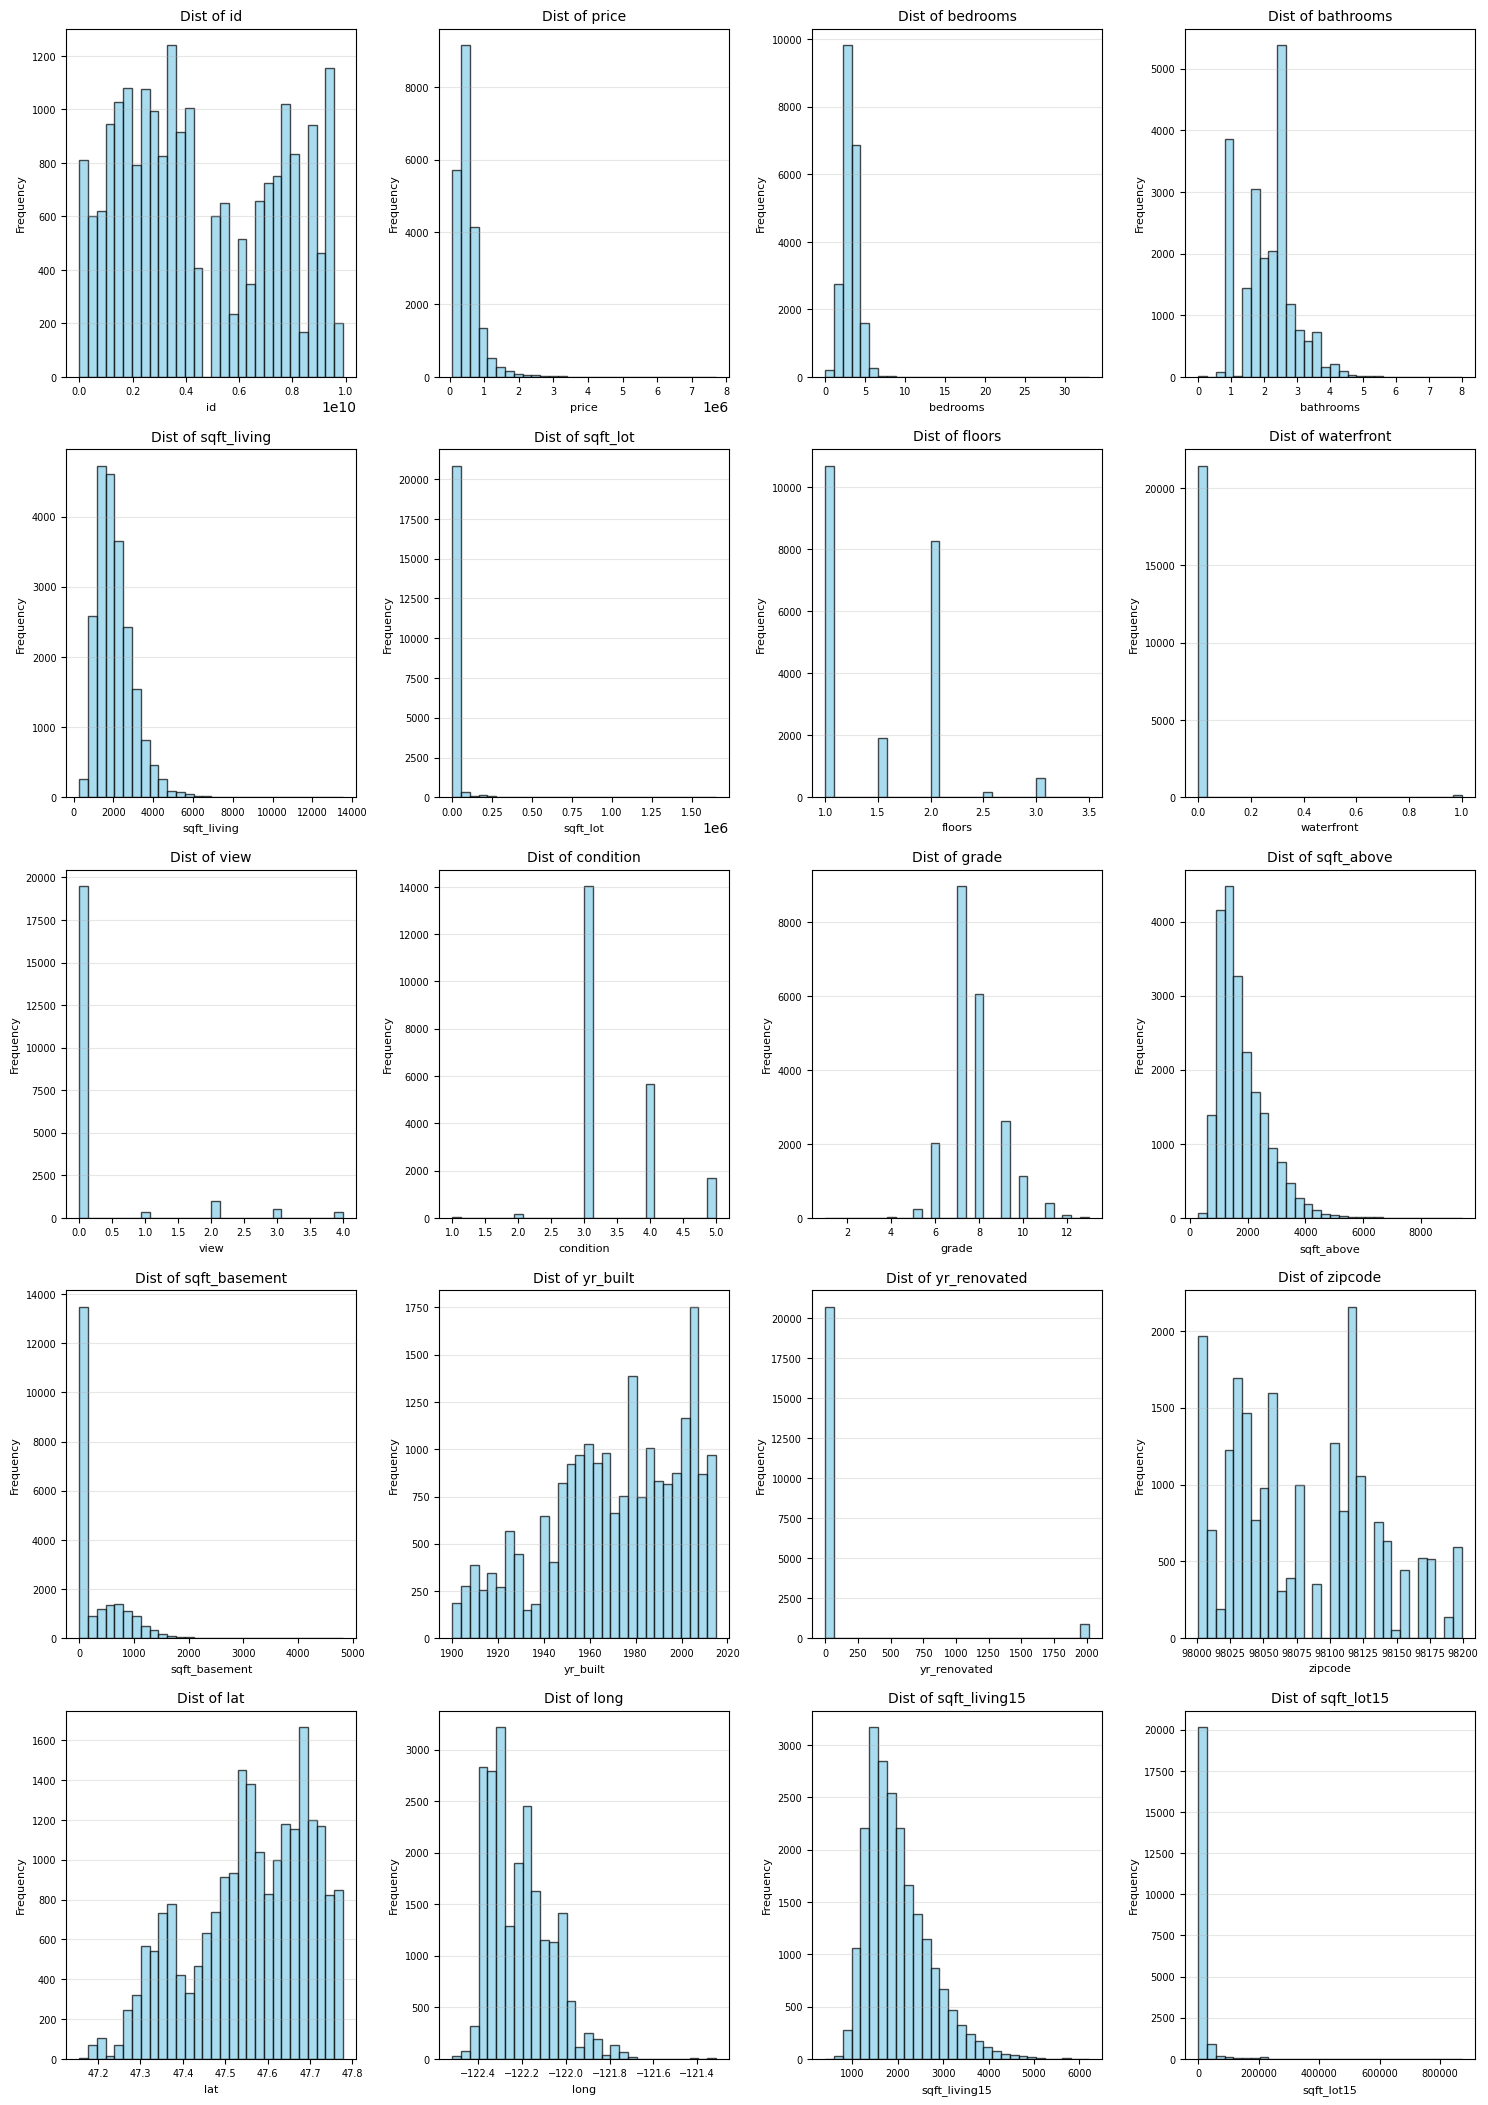

In [137]:
print("Generating Histograms...")
            
fig, axs = plt.subplots(6, 4, figsize=(15, 25))
axs = axs.ravel()

numeric_cols = data.select_dtypes(include='number').columns

for i, c in enumerate(numeric_cols):
    if i >= len(axs): # Safety break if columns exceed subplots
        break
    axs[i].hist(data[c], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axs[i].set_title(f'Dist of {c}', fontsize=10)
    axs[i].set_xlabel(c, fontsize=8)
    axs[i].set_ylabel('Frequency', fontsize=8)
    axs[i].tick_params(axis='both', which='major', labelsize=7)
    axs[i].grid(axis='y', alpha=0.3)

for j in range(len(numeric_cols), len(axs)):
    axs[j].set_visible(False)

plt.tight_layout()
plt.show()

In [138]:
data['date'] = pd.to_datetime(data['date'])
data['year_sold'] = data['date'].dt.year
data['month_sold'] = data['date'].dt.month
data['day_of_week'] = data['date'].dt.dayofweek  # Numeric: 0=Monday, ..., 6=Sunday
# delete
data = data.drop(columns=['date'])

In [139]:
data.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,month_sold,day_of_week
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,...,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,...,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,1
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,...,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,2
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,...,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,1
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,...,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,2


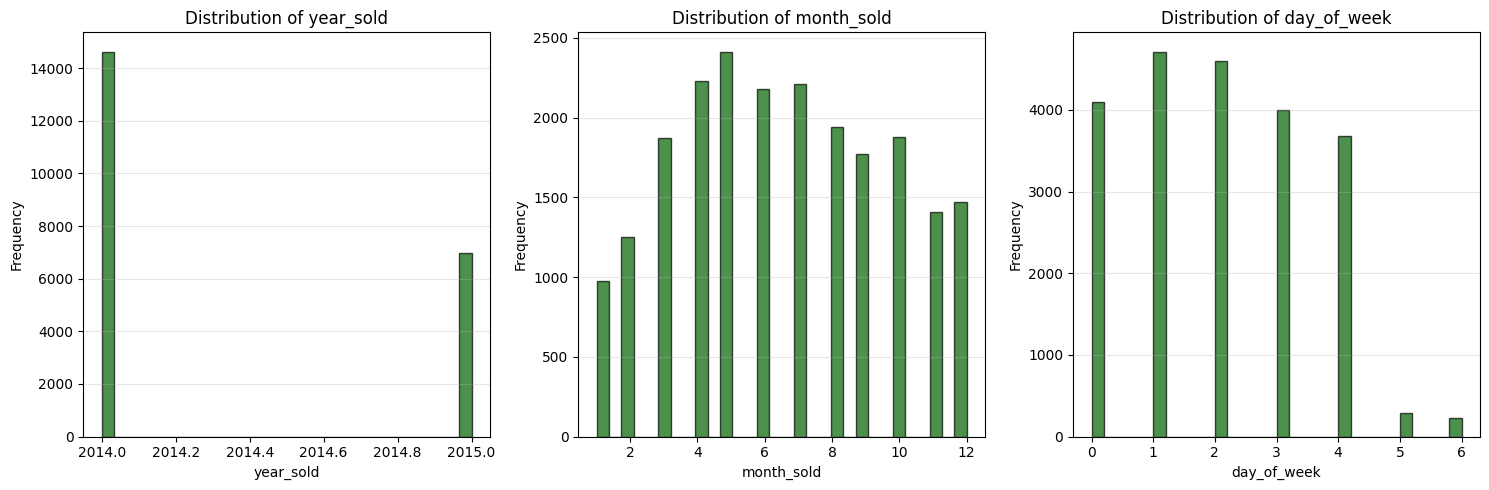

In [140]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axes = axs.ravel()
date_cols=data[['year_sold','month_sold', 'day_of_week']]

for i, c in enumerate(date_cols):
    axes[i].hist(date_cols[c], bins=30, edgecolor='black', alpha=0.7, color='darkgreen')
    axes[i].set_title(f'Distribution of {c}')
    axes[i].set_xlabel(c)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

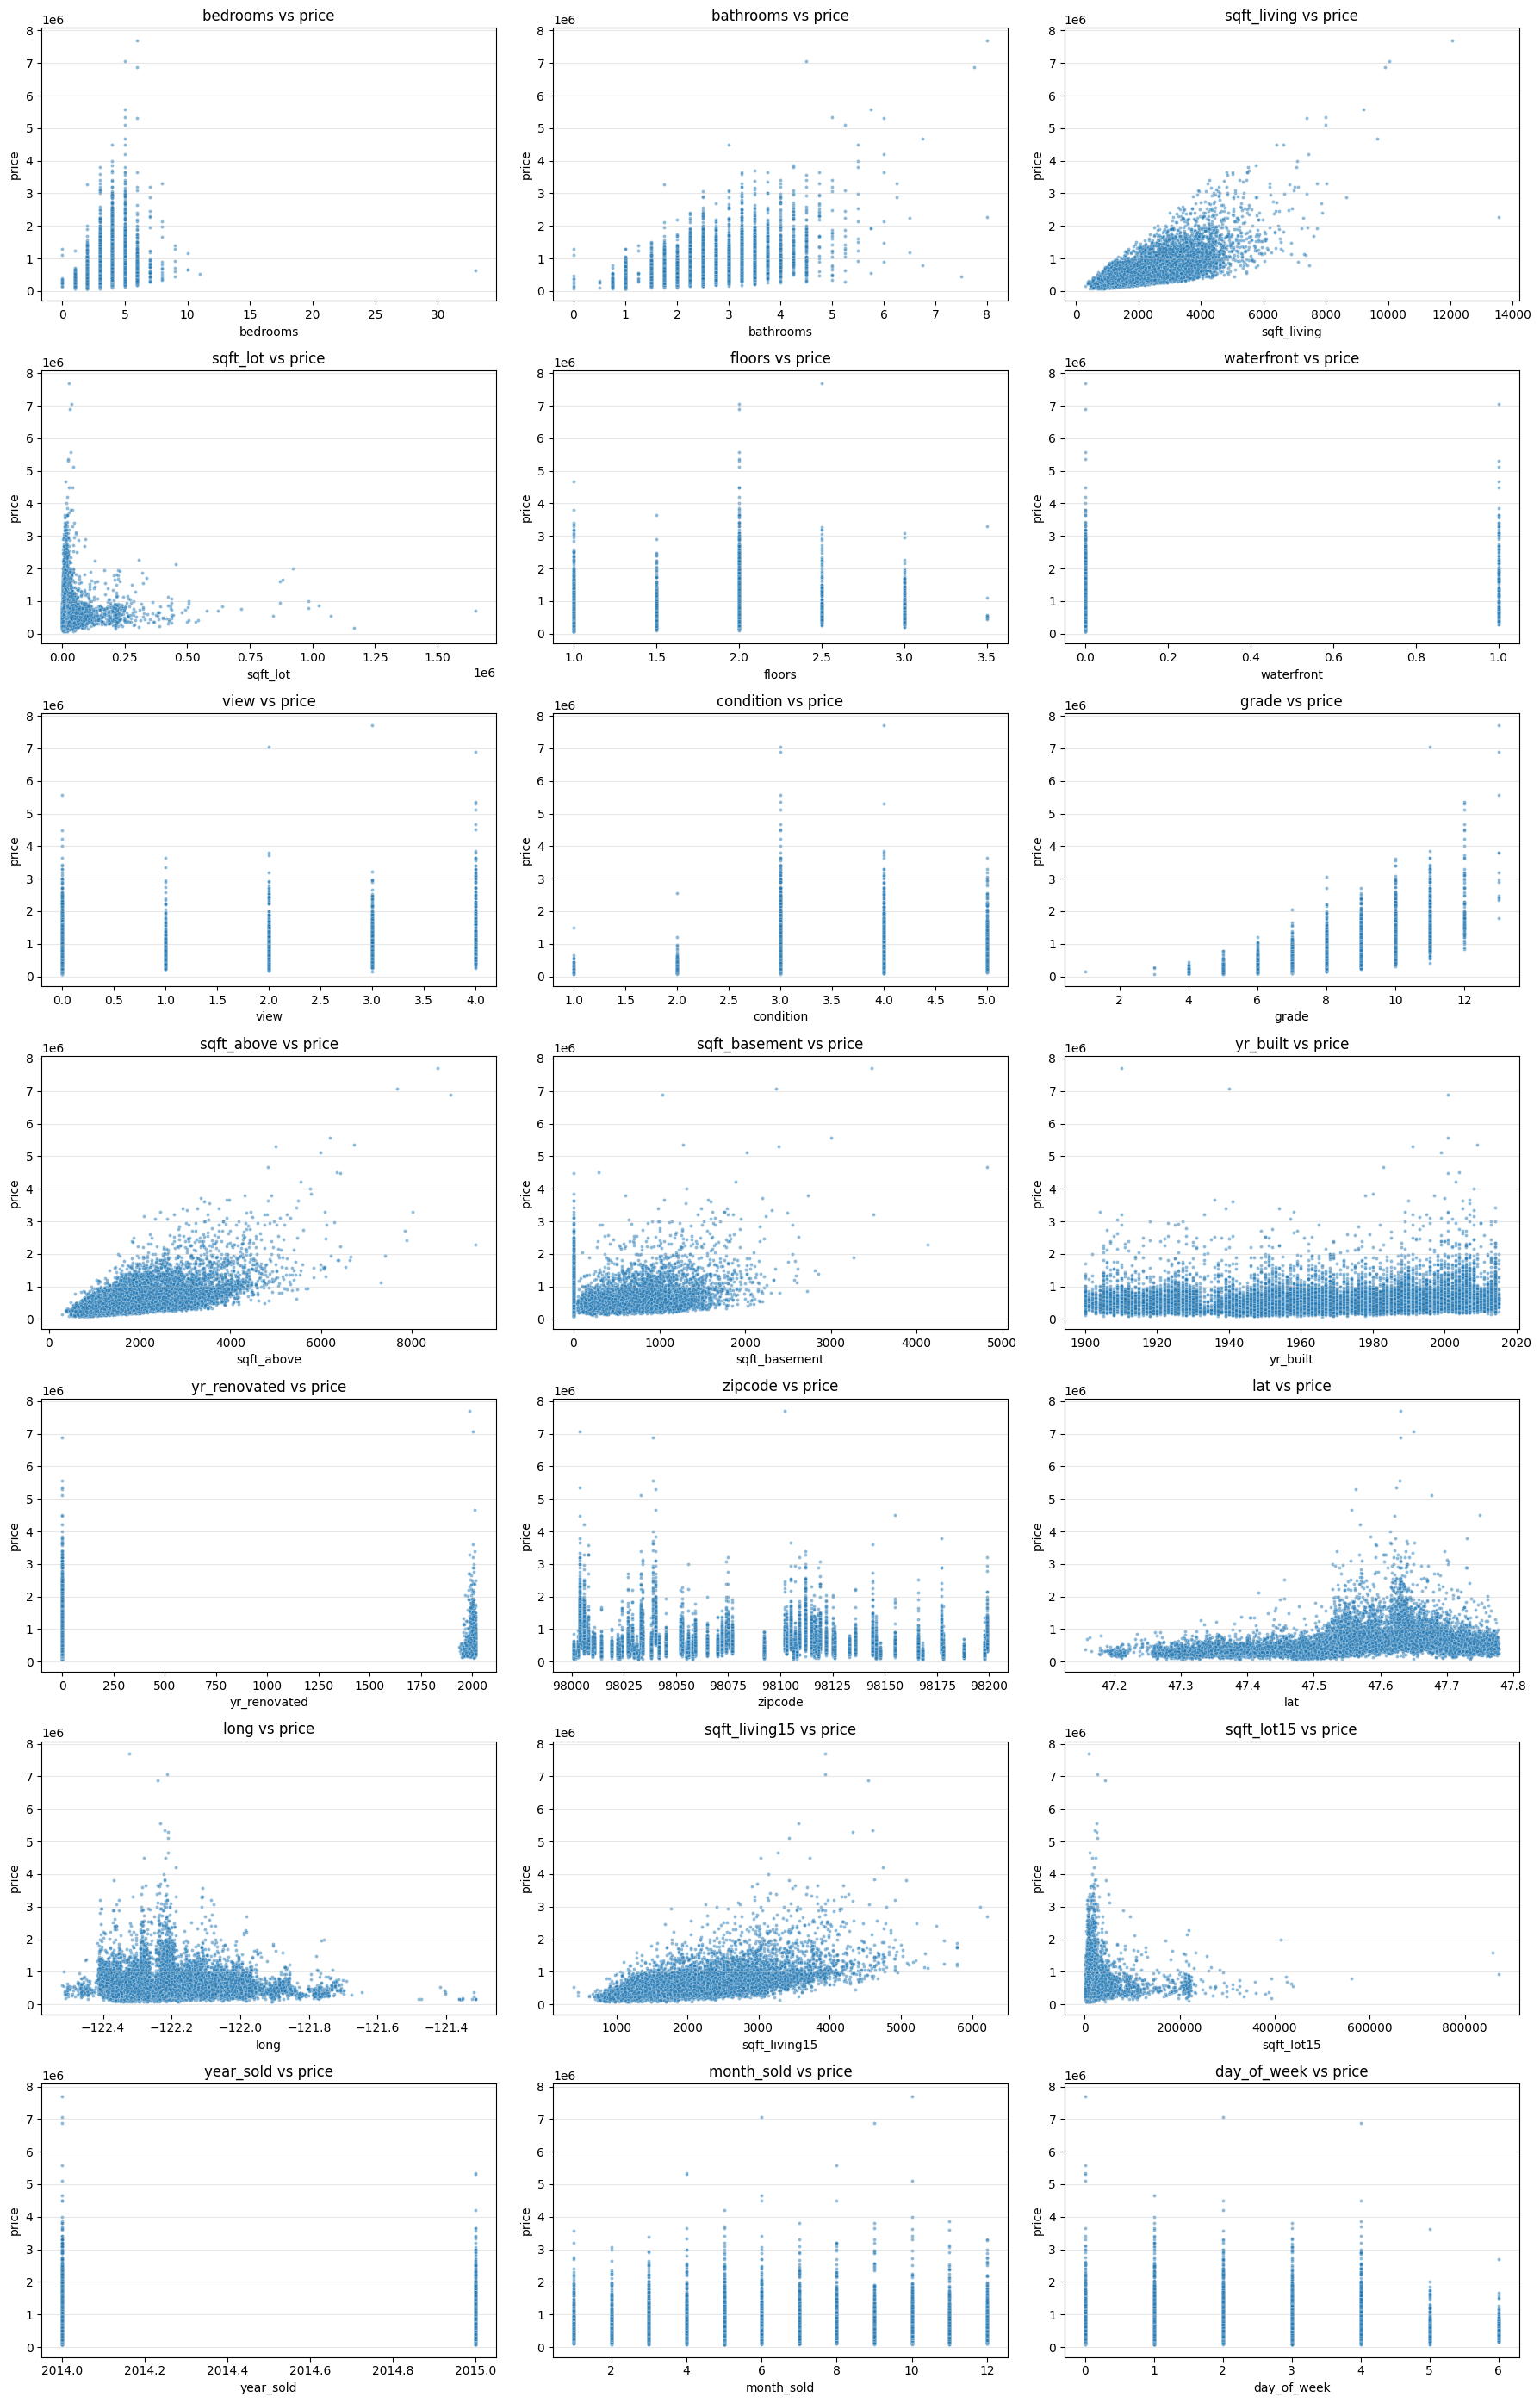

In [141]:
# Evaluation of the correlation of the target variable (price) and all the features
fig, axes = plt.subplots(7, 3, figsize=(18, 28))
axes = axes.ravel()

features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year_sold', 'month_sold', 'day_of_week']


for idx, col in enumerate(features):
    ax = axes[idx]
    sns.scatterplot(
        data=data,
        x=col,
        y='price',
        ax=ax,
        s=8,           # smaller points for readability
        alpha=0.5
    )
    ax.set_title(f'{col} vs price')
    ax.set_xlabel(col)
    ax.set_ylabel('price')
    axes[idx].grid(axis='y', alpha=0.3)

# Turn off any unused subplots (e.g., 24 slots, 21 features)
for j in range(len(features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

## Key Insights from Feature–Price Analysis

**Strongest Price Drivers**
- **Living area & size:** `sqft_living`, `sqft_above`, and neighborhood sizes (`sqft_living15`, `sqft_lot15`) show strong positive correlations with price.
- **Construction quality:** `grade` has an almost linear relationship with price — one of the most important predictors.
- **Location:** `lat`, `long`, and `zipcode` strongly influence price, confirming location as a critical factor.
- **Premium features:** `waterfront` and high `view` ratings create distinct high-price outliers.

**Moderate or Noisy Effects**
- `bathrooms`, `bedrooms`, and `sqft_basement` show positive but weaker relationships, with diminishing returns at higher values.

**Limited or No Predictive Power**
- `condition`, `yr_built`, `yr_renovated`, and sale timing (`year_sold`, `month_sold`, `day_of_week`) show little to no direct correlation with price.

**Bottom line:**  
House prices are primarily driven by **living space, build quality, and location**, with luxury/location-based features amplifying prices via outliers.


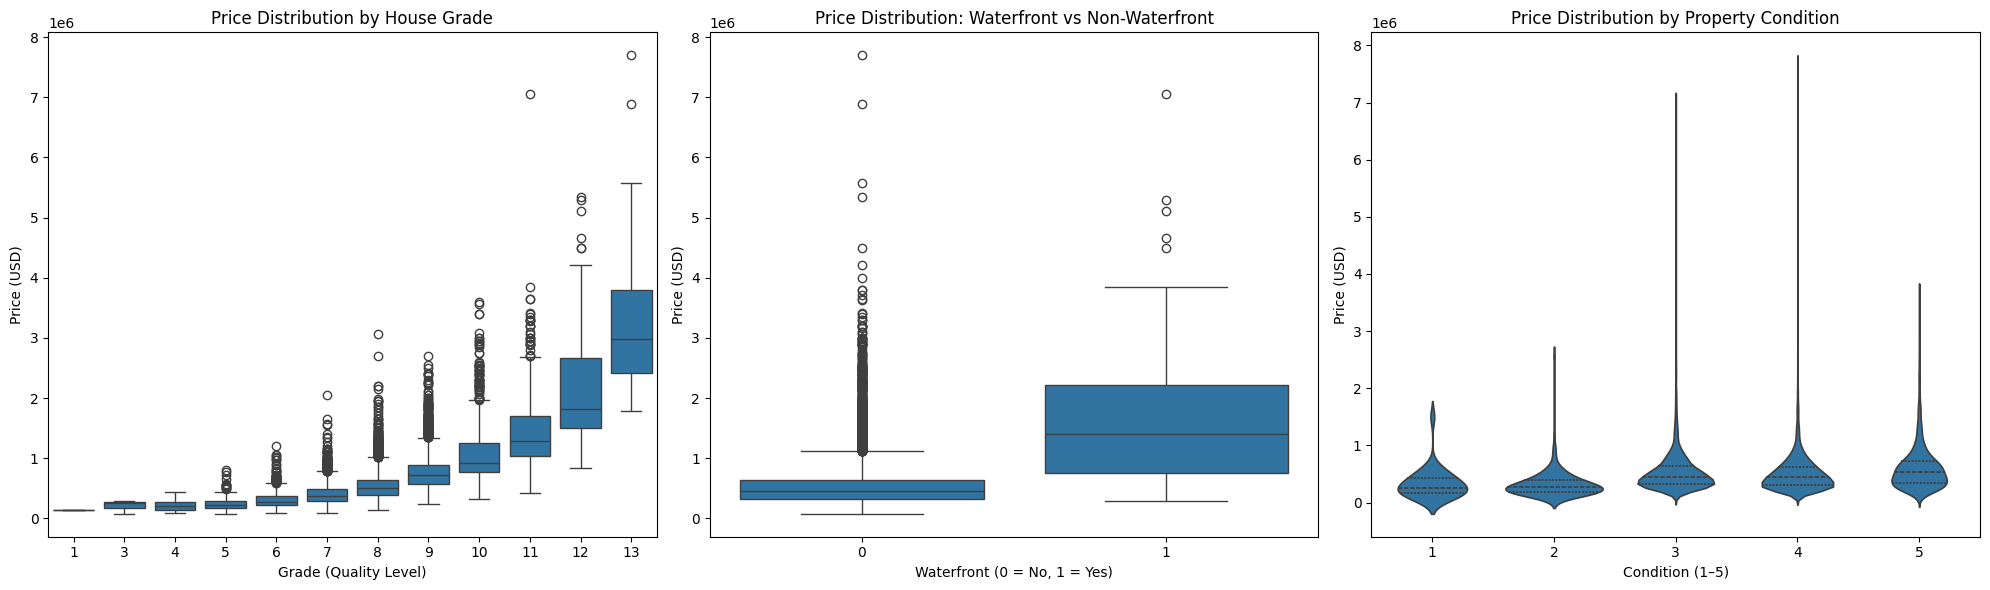

In [142]:
# Set up the figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- Plot 1: Price Distribution by Grade (Box Plot) ---
sns.boxplot(ax=axes[0], data=data, x='grade', y='price')
axes[0].set_title("Price Distribution by House Grade")
axes[0].set_xlabel("Grade (Quality Level)")
axes[0].set_ylabel("Price (USD)")

# --- Plot 2: Waterfront vs Price (Box Plot) ---
# Note: 'waterfront' is converted to string for clear categorical labels on the x-axis
# data['waterfront'] = data['waterfront'].astype(str)
sns.boxplot(ax=axes[1], data=data, x='waterfront', y='price')
axes[1].set_title("Price Distribution: Waterfront vs Non-Waterfront")
axes[1].set_xlabel("Waterfront (0 = No, 1 = Yes)")
axes[1].set_ylabel("Price (USD)")

# --- Plot 3: Price by Condition (Violin Plot) ---
# Note: 'condition' is converted to string for clear categorical labels on the x-axis
# data['condition'] = data['condition'].astype(str)
sns.violinplot(ax=axes[2], data=data, x='condition', y='price', inner='quartile')
axes[2].set_title("Price Distribution by Property Condition")
axes[2].set_xlabel("Condition (1–5)")
axes[2].set_ylabel("Price (USD)")

plt.tight_layout()
plt.show() # In a full Python environment, you would use this
# plt.savefig('combined_plots.png') # For saving the image

## Price Distribution Insights (Box & Violin Plots)

**1. House Grade vs. Price**
- Median price increases sharply with higher `grade`, showing a strong, near-monotonic trend.
- Higher grades (10–13) exhibit larger variance, reflecting the influence of premium locations and features.
- **Insight:** `grade` is one of the strongest single predictors of house price.

**2. Waterfront vs. Non-Waterfront**
- Waterfront homes have a **substantially higher median price**, with the entire distribution shifted upward.
- Non-waterfront homes show wider spread with many high-price outliers.
- **Insight:** Waterfront status creates a clear market segmentation and adds a major price premium.

**3. Property Condition vs. Price**
- Median prices for conditions 3–5 are relatively similar, indicating only a modest effect.
- Condition 3 and 4 dominate the dataset and span the widest price ranges.
- **Insight:** Good condition alone does not guarantee high price; size and location matter more.

**Overall takeaway:**  
Structural quality (`grade`) and premium location features (especially `waterfront`) dominate price formation, while `condition` plays a secondary role.


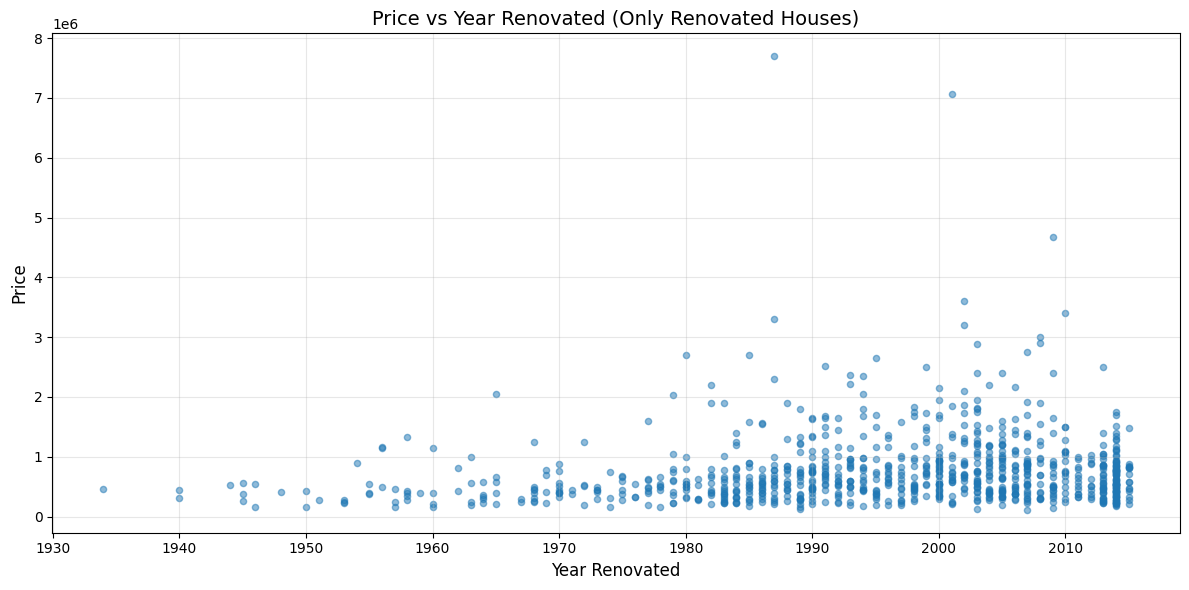

Number of renovated houses: 914
Year range: 1934 - 2015


In [143]:
renovated_houses = data[data['yr_renovated'] > 0]
plt.figure(figsize=(12, 6))
plt.scatter(renovated_houses['yr_renovated'], renovated_houses['price'], alpha=0.5, s=20)
plt.xlabel('Year Renovated', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Price vs Year Renovated (Only Renovated Houses)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print(f"Number of renovated houses: {len(renovated_houses)}")
print(f"Year range: {renovated_houses['yr_renovated'].min()} - {renovated_houses['yr_renovated'].max()}")

In [144]:
def categorize_renovation_year_numeric(year):
    if year == 0:
        return 0  # Not Renovated
    elif year < 1980:
        return 1  # Before 1980
    elif year < 1990:
        return 2  # 1980-1989
    elif year < 2000:
        return 3  # 1990-1999
    elif year < 2010:
        return 4  # 2000-2009
    else:
        return 5  # 2010+


data['was_renovated'] = (data['yr_renovated'] > 0).astype(int)

In [145]:
print(data['was_renovated'].nunique())
print(data['was_renovated'].value_counts())

2
was_renovated
0    20699
1      914
Name: count, dtype: int64


In [146]:
data['renovation_period'] = data['yr_renovated'].apply(categorize_renovation_year_numeric)
data['renovation_period'].value_counts()

renovation_period
0    20699
4      272
5      186
3      182
2      152
1      122
Name: count, dtype: int64

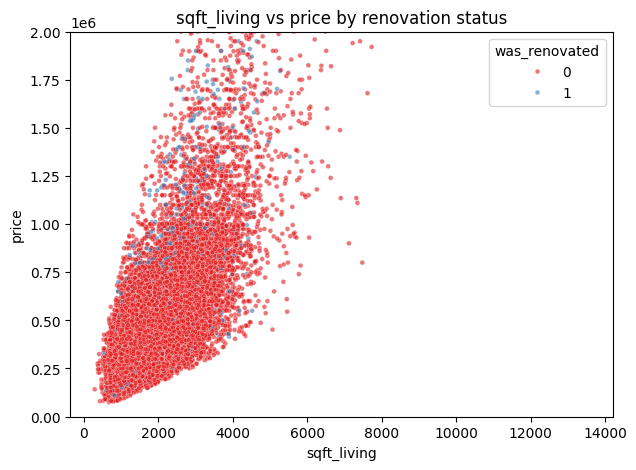

In [147]:
# Trying to see whether the column 'was_renovated' adds to the 'sqft_living'

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=data,
    x='sqft_living',
    y='price',
    hue='was_renovated',
    palette='Set1',
    s=12,
    alpha=0.6
)
plt.ylim(0, 2_000_000)    # zoom on typical prices
plt.title('sqft_living vs price by renovation status')
plt.show()

## 🛠️ Price Distribution Insights: Renovation Effects

**Renovated vs. Non-Renovated**
- Renovated homes have a **higher median price** and a **wider price spread** than non-renovated homes.
- High-end outliers are more extreme for renovated properties, indicating that many of the most expensive homes are renovated.
- **Insight:** Renovation is a strong positive indicator of price.

**Renovation Timing Matters**
- Homes that are **never renovated** have the lowest median price and tightest distribution.
- **Recent renovations (post-2000)** show the highest median prices and greatest variability.
- Older renovations (pre-2000) cluster closer to never-renovated homes, suggesting **renovation value depreciates over time**.

**Overall takeaway:**  
Renovation boosts home value, but **recency of renovation is critical**—newer upgrades deliver significantly larger price premiums than older ones.


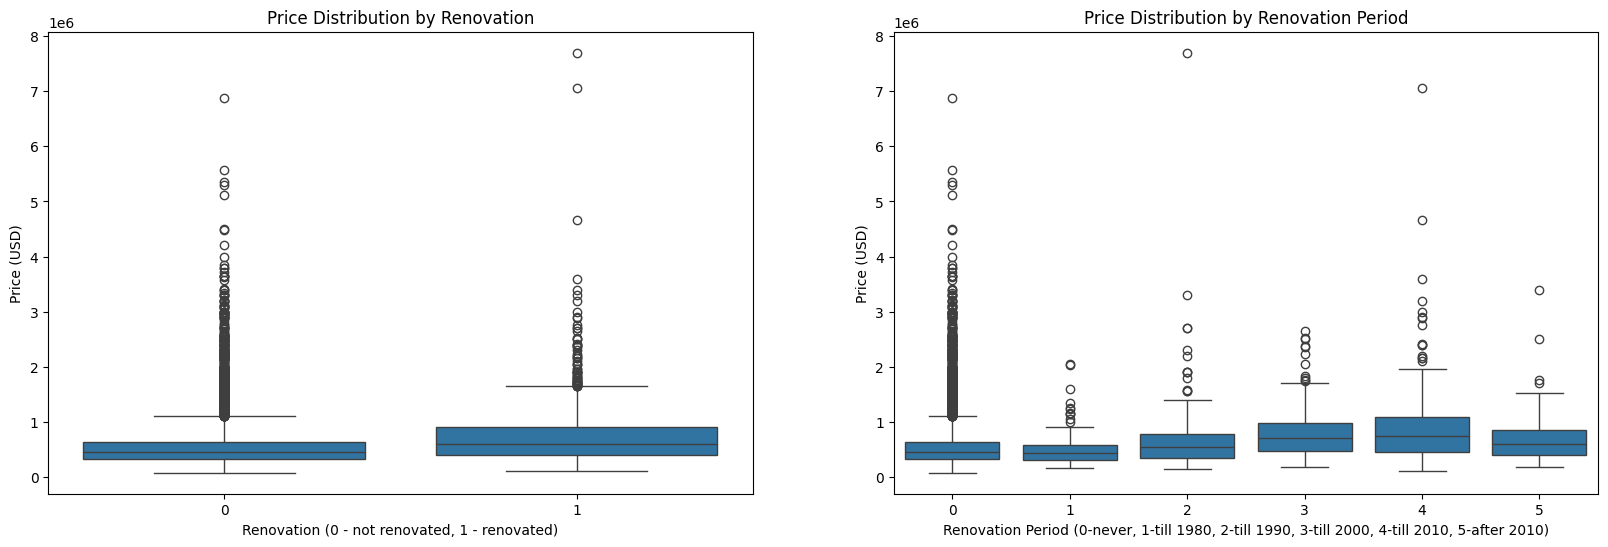

In [148]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Box plot — Price distribution by Renovation (was_renovated)
sns.boxplot(data=data, x='was_renovated', y='price', ax=axes[0])
axes[0].set_title("Price Distribution by Renovation")
axes[0].set_xlabel("Renovation (0 - not renovated, 1 - renovated)")
axes[0].set_ylabel("Price (USD)")

# Box plot — Price distribution by Renovation (renovation_period)
sns.boxplot(data=data, x='renovation_period', y='price', ax=axes[1])
axes[1].set_title("Price Distribution by Renovation Period")
axes[1].set_xlabel("Renovation Period (0-never, 1-till 1980, 2-till 1990, 3-till 2000, 4-till 2010, 5-after 2010)")
axes[1].set_ylabel("Price (USD)")
plt.show()

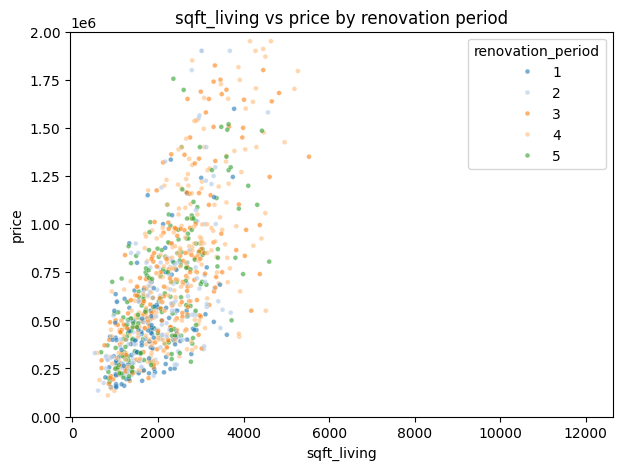

In [149]:
# Zooming in into renovated houses
renovated_houses=data[data['was_renovated']==1]

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=renovated_houses,
    x='sqft_living',
    y='price',
    hue='renovation_period',
    palette='tab20',
    s=12,
    alpha=0.6
)
plt.ylim(0, 2_000_000)    # zoom on typical prices
plt.title('sqft_living vs price by renovation period')
plt.show()

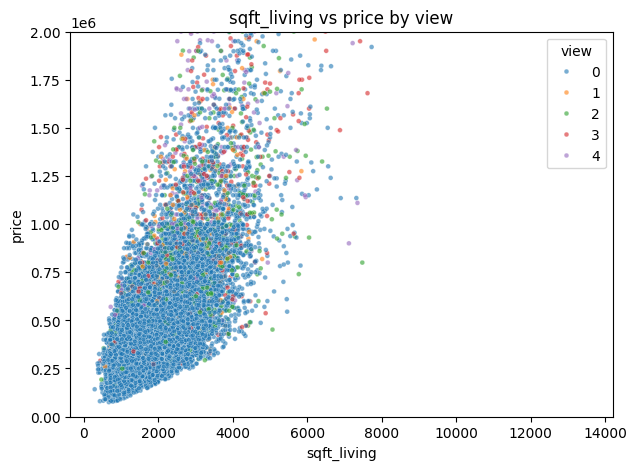

In [150]:
# Trying to see whether the column 'waterfront' adds to the 'sqft_living'

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=data,
    x='sqft_living',
    y='price',
    hue='view',
    palette='tab10',
    s=12,
    alpha=0.6
)
plt.ylim(0, 2_000_000)    # zoom on typical prices
plt.title('sqft_living vs price by view')
plt.show()

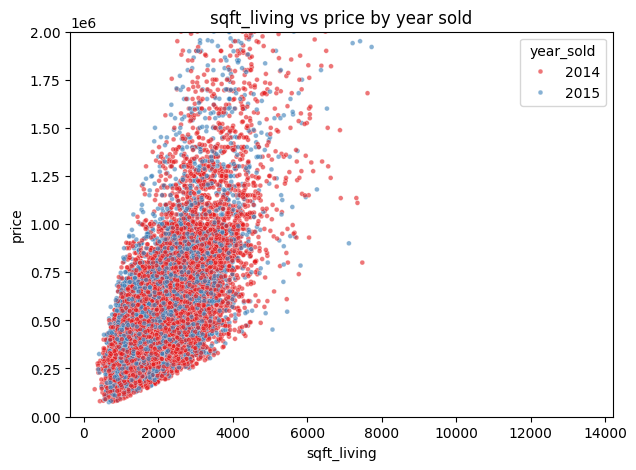

In [151]:
# Trying to see whether the column 'was_renovated' adds to the 'sqft_living'

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=data,
    x='sqft_living',
    y='price',
    hue='year_sold',
    palette='Set1',
    s=12,
    alpha=0.6
)
plt.ylim(0, 2_000_000)    # zoom on typical prices
plt.title('sqft_living vs price by year sold')
plt.show()

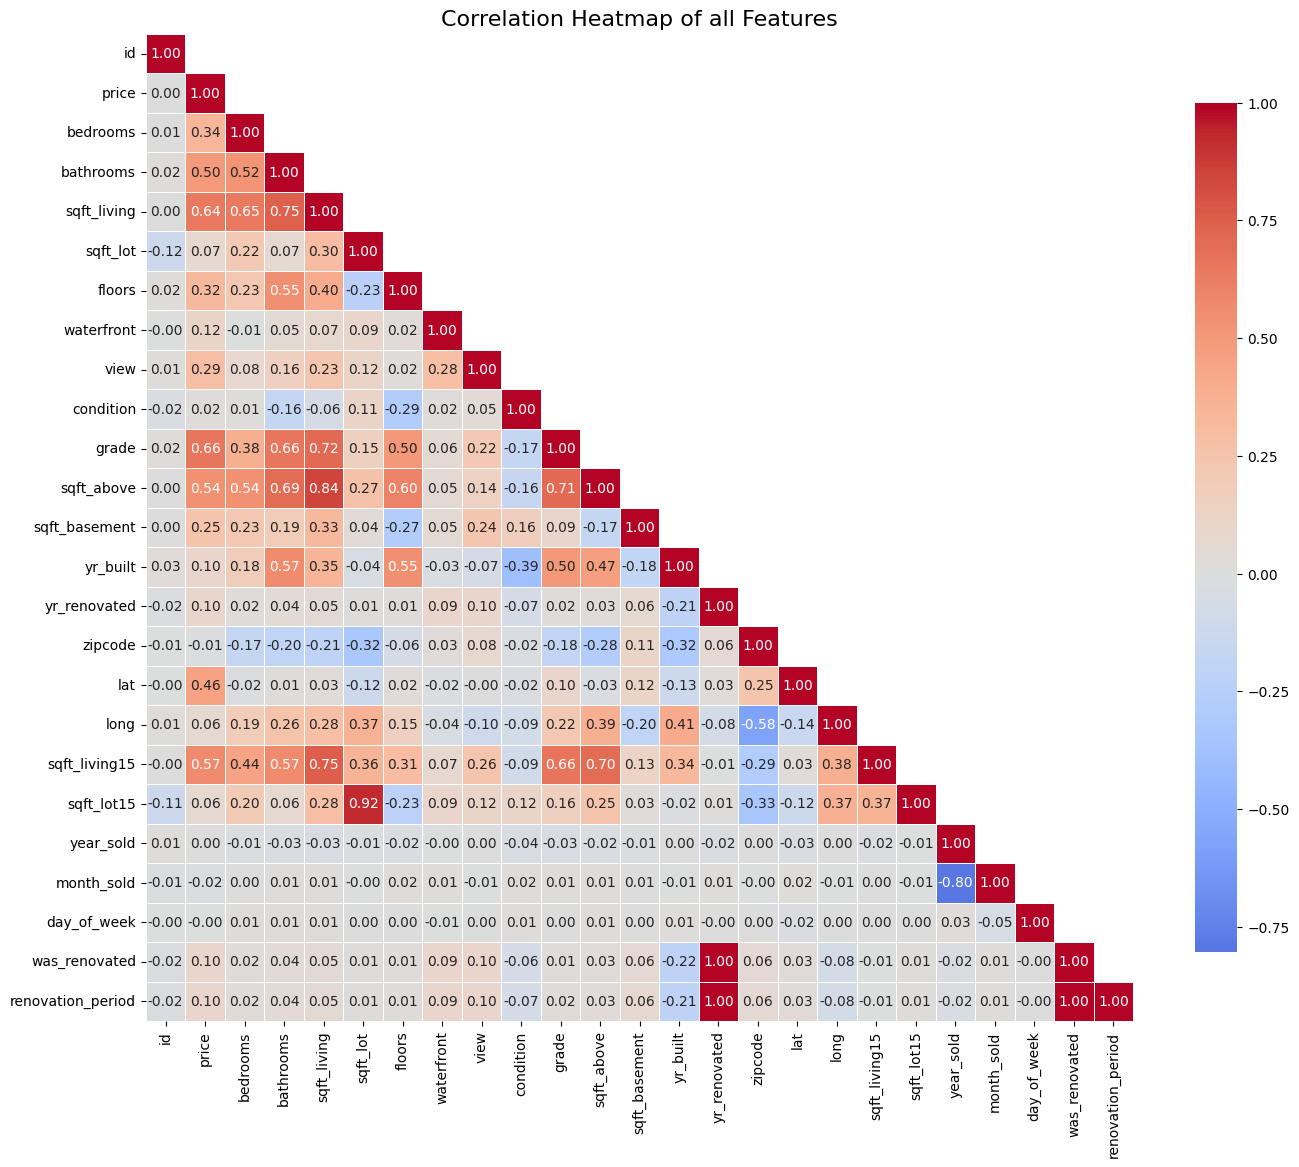

In [152]:
# Calculate correlation matrix for all features and target variable
correlation_matrix = data.corr(method='spearman')

# Fix 2: Mask upper triangle, keep diagonal visible
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
# k=1 means mask starts ONE diagonal above main diagonal

# Create heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of all Features', fontsize=16)
plt.tight_layout()
plt.show()

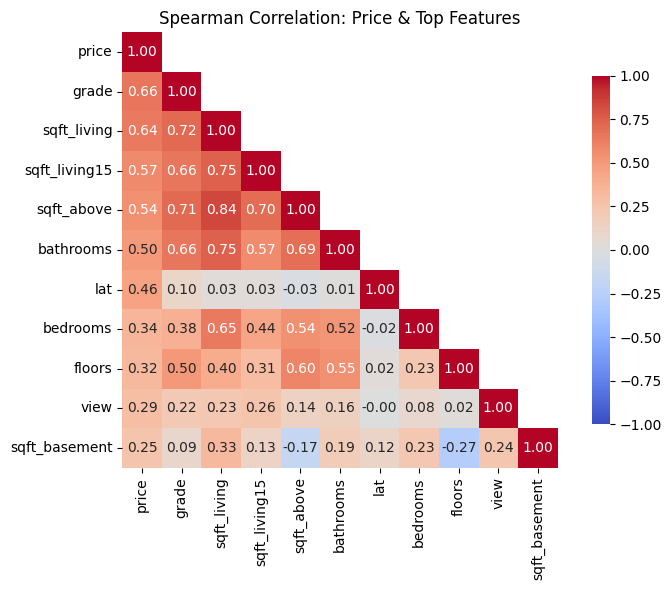

In [153]:
# For the presentation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Compute Spearman correlations
corr_spear = data.corr(method="spearman")

# 2. Sort features by absolute correlation with price (excluding id if present)
target = "price"
corr_target = corr_spear[target].drop(labels=[target, "id"], errors="ignore")
top_feats = corr_target.abs().sort_values(ascending=False).head(10).index

# 3. Build a smaller correlation matrix with price + top features
cols_for_plot = [target] + list(top_feats)
corr_small = corr_spear.loc[cols_for_plot, cols_for_plot]

mask = np.triu(np.ones_like(corr_small, dtype=bool), k=1)
# 4. Plot a cleaner heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_small,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Spearman Correlation: Price & Top Features")
plt.tight_layout()
plt.show()

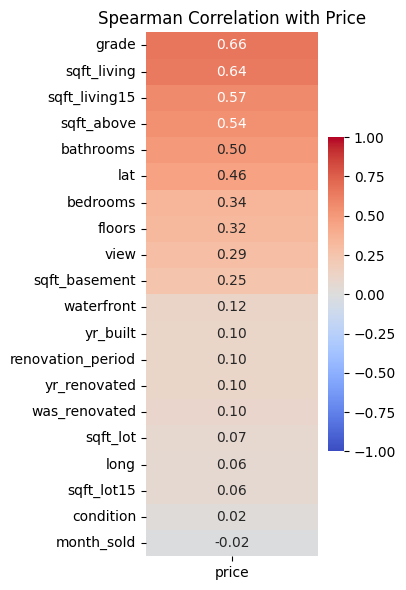

In [154]:
# For the presentation
top_feats = corr_target.abs().sort_values(ascending=False).head(20).index
plt.figure(figsize=(4, 6))
sns.heatmap(
    corr_target.loc[top_feats].to_frame(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    cbar_kws={"shrink": 0.6}
)
plt.title("Spearman Correlation with Price")
plt.ylabel("")
plt.tight_layout()
plt.show()

## Correlation-Based Insights (Spearman)

**Strongest Positive Predictors**
- **Grade (ρ = 0.66):** Single strongest driver of price; captures overall build quality.
- **sqft_living (ρ = 0.64):** Living space size is nearly as influential as grade.
- **sqft_living15 (ρ = 0.57):** Strong proxy for neighborhood quality and comparable values.
- **sqft_above (ρ = 0.54)** and **bathrooms (ρ = 0.50):** Important but secondary size-related factors.

**Unique Role of Location**
- **Latitude (ρ = −0.46):** Strong negative correlation with price, indicating that specific (lower-latitude) geographic areas are disproportionately expensive.
- Latitude is **nearly uncorrelated** with size and quality features, meaning location affects price **independently** of house characteristics.

**Multi-Collinearity Among Top Features**
- Size and quality features are highly correlated with each other:
  - `sqft_living` ↔ `sqft_above` (0.84)
  - `sqft_living` ↔ `bathrooms` (0.75)
  - `sqft_living` ↔ `grade` (0.72)
- This indicates redundancy and motivates feature selection or regularization in modeling.

**Weak or Negligible Predictors**
- **Renovation & age:** `yr_built`, `yr_renovated`, `was_renovated` (ρ ≈ 0.10)
- **Lot size:** `sqft_lot`, `sqft_lot15` (ρ < 0.08)
- **Condition & timing:** `condition`, `month_sold` (ρ ≈ 0)

**Bottom line:**  
House prices are primarily driven by **quality (grade)**, **living space**, and **location**, with strong redundancy among size-related features and minimal influence from age, renovation status, or lot size.


# Feature Engineering

## Planned Engineered Features

### 1. Living-Area & Utilization Features
These features capture usable space, layout efficiency, and how intensively the lot is used.
- `total_sqft = sqft_living + sqft_basement`
- `living_to_lot_ratio = sqft_living / sqft_lot`
- `bath_per_bed = bathrooms / bedrooms`
- `living15_diff = sqft_living - sqft_living15`  
  *(Relative size compared to nearby homes)*
- `basement_share = sqft_basement / (sqft_living + sqft_basement + 1)`
- `has_basement = (sqft_basement > 0).astype(int)`

### 2. Distribution-Stabilizing Transformations
Applied to reduce right skew and improve linear model performance.
- `log_price`
- `log_sqft_living`
- `log_sqft_lot`

### 3. Neighborhood & Location Features
Designed to capture spatial density and local market effects.
- `lot_per_living = sqft_lot / sqft_living`
- *(Planned)* location-based features:
  - Latitude/longitude clustering
  - Zipcode-level mean or median price
  - Distance-to-city-center or major hubs

### 4. Age, Condition & Renovation Features
These features model depreciation and the impact of renovations.
- `house_age = year_sold - yr_built`
- `since_renovation = np.where(yr_renovated > 0, year_sold - yr_renovated, house_age)`
- `was_renovated = (yr_renovated > 0).astype(int)`

**Rationale:**  
These engineered features aim to reduce skewness, capture nonlinear effects, encode neighborhood context, and mitigate multicollinearity among raw size-related variables.


In [155]:
# ==============================
# 1. Living-area related features
# ==============================

# Total usable square footage: above-ground + basement
data['total_sqft'] = data['sqft_living'] + data['sqft_basement']

# How intensively the lot is used (protect against division by zero)
data['living_to_lot_ratio'] = (data['sqft_lot'] / data['sqft_living'])

# Bathrooms per bedroom as a simple comfort indicator
data['bath_per_bed'] = data['bathrooms'] / (data['bedrooms'])

# Difference between house size and neighborhood average size
data['living15_diff'] = data['sqft_living'] - data['sqft_living15']

# Share of total area that is basement
data['basement_share'] = data['sqft_basement'] / (
    data['sqft_living'] + data['sqft_basement'] + 1
)

# Binary flag: does the house have a basement?
data['has_basement'] = (data['sqft_basement'] > 0).astype(int)

# Log transforms for skewed variables (add 1 to avoid log(0))
data['log_price'] = np.log1p(data['price'])
data['log_sqft_living'] = np.log1p(data['sqft_living'])
data['log_sqft_lot'] = np.log1p(data['sqft_lot'])

In [156]:
# Neighborhood / location: density / land use
data['lot_per_living'] = data['sqft_lot'] / data['sqft_living']

In [157]:
# ==========================================
# 3. Age, condition, renovation-related features
# ==========================================

# House age at time of sale
data['house_age'] = data['year_sold'] - data['yr_built']

# Years since last renovation (or age if never renovated)
data['since_renovation'] = np.where(
    data['yr_renovated'] > 0,
    data['year_sold'] - data['yr_renovated'],
    data['house_age']
)

# Simple combined quality score (condition + grade)
data['quality_score'] = data['condition'] + data['grade']

In [158]:
# 1. Open a real file on disk to catch the errors
# This gives subprocess access to a real "fileno" (file descriptor)
with open("mcp_debug.log", "w") as log_file:
    
    # 2. Save the original Jupyter stderr (so we can restore it later)
    original_stderr = sys.stderr
    
    try:
        # 3. Redirect stderr to the real file
        sys.stderr = log_file
        
        # 4. Initialize and connect
        # FastMCP will now inherit the "real" file instead of the Jupyter stream
        client = Client("./mcp_utils.py")
        
        async with client:
            tools = await client.list_tools()
            print("Tools found:", [t.name for t in tools])

            result = await client.call_tool(
                "upload_file",
                {"path": "./kc_house_data.csv"}
            )

            print("Upload tool result:", result.structured_content["result"])

            # result = await client.call_tool(
            #     "get_columns_info"
            # )

            # print("\nColumns info:", result.structured_content["result"])

            # print("\nDownloading data for EDA...")
            # data_result = await client.call_tool("download_data")
            fe_result = await client.call_tool("engineer_features")
            print("Feature Engineering tool result:", fe_result.structured_content["result"])

            # result_dict = data_result.structured_content
            fe_data_result = await client.call_tool("download_fe_data")
            fe_result_dict = fe_data_result.structured_content

            if "result" not in fe_result_dict:
                print("Error: The tool did not return a 'result' key in structured content.")
                print(f"Raw structured content: {fe_result_dict}")
                raise Exception("MCP Tool call failed to return 'result'.")
            
            json_string = fe_result_dict["result"]

            raw_data = json.loads(json_string) 

            data_fe = pd.DataFrame(raw_data) 
            print(f"Feature Engineered Data successfully downloaded. Client-side shape: {data_fe.shape}")
            
    except Exception as e:
        print(f"An error occurred: {e}")
        
    finally:
        # 5. Restore Jupyter's stderr so other cells work normally
        sys.stderr = original_stderr

# You can inspect the log file afterwards if something goes wrong
# !type mcp_debug.log

Tools found: ['upload_file', 'get_columns_info', 'download_data', 'engineer_features', 'add_features', 'download_fe_data', 'run_experiment', 'get_model_coefficients', 'list_experiments', 'predict_house_price', 'set_production_model', 'get_production_model', 'get_model_list_summary']
Upload tool result: Data successfully loaded. Shape: (21613, 21)
Feature Engineering tool result: Feature Engineering Successful. Shape: (21613, 38)
Feature Engineered Data successfully downloaded. Client-side shape: (21613, 38)


In [159]:
data_fe.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year_sold', 'month_sold', 'day_of_week',
       'was_renovated', 'renovation_period', 'total_sqft',
       'living_to_lot_ratio', 'bath_per_bed', 'living15_diff',
       'basement_share', 'has_basement', 'log_price', 'log_sqft_living',
       'log_sqft_lot', 'lot_per_living', 'house_age', 'since_renovation',
       'quality_score'],
      dtype='object')

In [160]:
# ==============================
# 4. Track original vs engineered features
# ==============================

# List of ORIGINAL features (after basic cleaning, before new FE)
original_features = [
    'bedrooms', 'bathrooms',
    'sqft_living', 'sqft_lot',
    'floors', 'waterfront', 'view',
    'condition', 'grade',
    'sqft_above', 'sqft_basement',
    'yr_built', 'yr_renovated',
    'zipcode', 'lat', 'long',
    'sqft_living15', 'sqft_lot15',
    'year_sold', 'month_sold', 'day_of_week',
]

# List of ENGINEERED features (including date- and renovation-based)
engineered_features = [
    # renovation flags
    'was_renovated', 'renovation_period',
    # living-area related
    'total_sqft',              # sqft_living + sqft_basement
    'living_to_lot_ratio',     # sqft_lot / sqft_living
    'bath_per_bed',            # bathrooms / bedrooms
    'living15_diff',           # sqft_living - sqft_living15
    'basement_share',          # sqft_basement / (sqft_living + sqft_basement)
    'has_basement',            # 1 if sqft_basement > 0 else 0
    # neighborhood / density
    'lot_per_living',          # sqft_lot / sqft_living
    # age and renovation
    'house_age',               # year_sold - yr_built
    'since_renovation'         # years since last renovation (or age)
]

print("Number of original features:", len(original_features))
print("Number of engineered features:", len(engineered_features))

Number of original features: 21
Number of engineered features: 11


# Experiment-1: Original Features

In [161]:
# 1. Open a real file on disk to catch the errors
# This gives subprocess access to a real "fileno" (file descriptor)
with open("mcp_debug.log", "w") as log_file:
    
    # 2. Save the original Jupyter stderr (so we can restore it later)
    original_stderr = sys.stderr
    
    try:
        # 3. Redirect stderr to the real file
        sys.stderr = log_file
        
        # 4. Initialize and connect
        # FastMCP will now inherit the "real" file instead of the Jupyter stream
        client = Client("./mcp_utils.py")
        
        async with client:
            tools = await client.list_tools()
            print("Tools found:", [t.name for t in tools])

            result = await client.call_tool(
                "upload_file",
                {"path": "./kc_house_data.csv"}
            )

            print("Upload tool result:", result.structured_content["result"])

            fe_result = await client.call_tool("engineer_features")
            print("Feature Engineering tool result:", fe_result.structured_content["result"])

            # result_dict = data_result.structured_content
            fe_data_result = await client.call_tool("download_fe_data")
            fe_result_dict = fe_data_result.structured_content

            if "result" not in fe_result_dict:
                print("Error: The tool did not return a 'result' key in structured content.")
                print(f"Raw structured content: {fe_result_dict}")
                raise Exception("MCP Tool call failed to return 'result'.")
            
            json_string = fe_result_dict["result"]

            raw_data = json.loads(json_string) 

            data_fe = pd.DataFrame(raw_data) 
            print(f"Feature Engineered Data successfully downloaded. Client-side shape: {data_fe.shape}")


            linear_config = {
                "model_name": "LinearRegression",
                "hyperparameters": {}
            }

            baseline_train_config = {
                "target_column": "price",
                "test_size": 0.2,
                "random_state": 42
            }

            print("\n--- Running Experiment 1 (Baseline Features) ---")
            exp_result = await client.call_tool(
                "run_experiment",
                {
                    "mod_config": linear_config,
                    "train_config": baseline_train_config,
                    "feature_list": data_fe[original_features].columns.tolist()
                }
            )

            run_summary = exp_result.structured_content["result"]

            if run_summary.get("status") == "SUCCESS":
                print(f"Experiment Run ID: {run_summary['run_id']}")
                print(f"   Model: {run_summary['model']}")
                print(f"   Train R²: {run_summary['train_r2']:.4f}")
                print(f"   Train RMSE: {run_summary['train_rmse']:.0f}")
                print(f"   Test R²: {run_summary['test_r2']:.4f}")
                print(f"   Test RMSE: {run_summary['test_rmse']:.0f}")
                print(f"   Test RMSE % Mean: {run_summary['test_rmse_pct_mean']:.2f}%")
                print(f"   Test RMSE % Range: {run_summary['test_rmse_pct_range']:.2f}%")
                print(f"   Training Time (sec): {run_summary['training_time_sec']:.2f}")
            else:
                print(f"Experiment failed: {run_summary.get('error', 'Unknown Error')}")

            # In MCP_Example.ipynb (Inside the async with client: block)

            # ... (After Experiment 1 is run and its summary is stored in run_summary_1) ...

            # Get the Run ID from the successful experiment
            run_id_1 = run_summary['run_id']

            # --- NEW STEP: Get Coefficients for Visualization ---
            print(f"\n--- Retrieving Coefficients for Run ID: {run_id_1[:8]}... ---")

            coef_result = await client.call_tool(
                "get_model_coefficients",
                {"run_id": run_id_1}
            )

            coef_data = coef_result.structured_content["result"]
            print("Coefficient Retrieval Successful")

            if isinstance(coef_data, str) and coef_data.startswith("Error:"):
                print(f"Coefficient retrieval failed: {coef_data}")
                # You might raise an exception here if this is critical
            else:
                # 1. Get coefficients and put them in a DataFrame
                # print(coef_data)
                coef = np.array(coef_data["coefficients"])
                features = coef_data["features"]
            
            set_prod_result = await client.call_tool(
                "set_production_model",
            )

            prod_set_content = set_prod_result.structured_content["result"]

            # --- 3. VERIFY the new Production Model status ---
            print("\n--- Verifying Current Production Status ---")

            get_prod_result = await client.call_tool("get_production_model")
            prod_model_data = get_prod_result.structured_content["result"]

            verified_id = prod_model_data.get("production_run_id")
            verified_summary = prod_model_data.get("summary", {})

            if verified_id:
                print(f"   Best Model Fetch SUCCESSFUL.")
                print(f"   Model Name: {verified_summary.get('model')}")
            else:
                print(f"   VERIFICATION FAILED. Current ID: {verified_id}")
                
                
    except Exception as e:
        print(f"An error occurred: {e}")
        
    finally:
        # 5. Restore Jupyter's stderr so other cells work normally
        sys.stderr = original_stderr

# You can inspect the log file afterwards if something goes wrong
# !type mcp_debug.log

Tools found: ['upload_file', 'get_columns_info', 'download_data', 'engineer_features', 'add_features', 'download_fe_data', 'run_experiment', 'get_model_coefficients', 'list_experiments', 'predict_house_price', 'set_production_model', 'get_production_model', 'get_model_list_summary']
Upload tool result: Data successfully loaded. Shape: (21613, 21)
Feature Engineering tool result: Feature Engineering Successful. Shape: (21613, 38)
Feature Engineered Data successfully downloaded. Client-side shape: (21613, 38)

--- Running Experiment 1 (Baseline Features) ---
Experiment Run ID: a1ff82c2-837c-44ab-bc4a-5c57765b485a
   Model: LinearRegression
   Train R²: 0.7007
   Train RMSE: 197753
   Test R²: 0.7026
   Test RMSE: 212040
   Test RMSE % Mean: 38.60%
   Test RMSE % Range: 3.86%
   Training Time (sec): 1.16

--- Retrieving Coefficients for Run ID: a1ff82c2... ---
Coefficient Retrieval Successful

--- Verifying Current Production Status ---
   Best Model Fetch SUCCESSFUL.
   Model Name: Linea

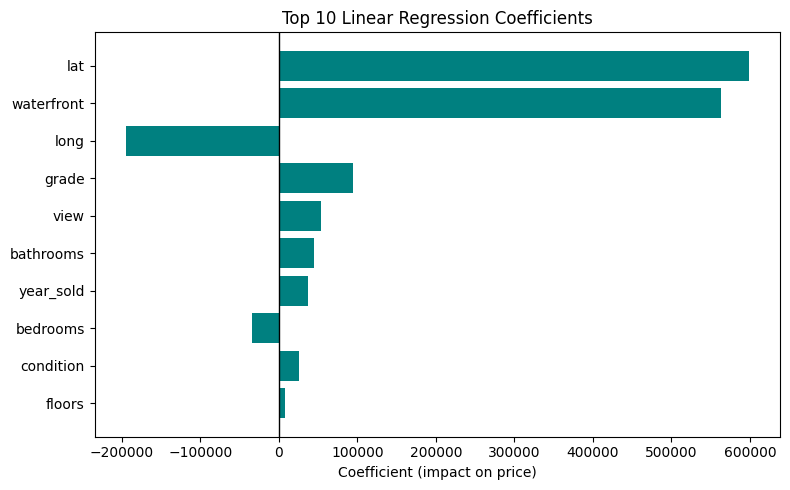

In [162]:
coef_df = pd.DataFrame({
    "feature": features,
    "coefficient": coef
})

# 2. Sort by absolute impact and take top 10
coef_df["abs_coef"] = coef_df["coefficient"].abs()
top10 = coef_df.sort_values("abs_coef", ascending=False).head(10)

# 3. Plot (show sign by using the original coefficient)
plt.figure(figsize=(8, 5))
plt.barh(top10["feature"][::-1], top10["coefficient"][::-1], color="teal")
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Coefficient (impact on price)")
plt.title(f"Top 10 Linear Regression Coefficients")
plt.tight_layout()
plt.show()

# Experiment 2: Original Features with Normalization

In [163]:
# 1. Open a real file on disk to catch the errors
# This gives subprocess access to a real "fileno" (file descriptor)
with open("mcp_debug.log", "w") as log_file:
    
    # 2. Save the original Jupyter stderr (so we can restore it later)
    original_stderr = sys.stderr
    
    try:
        # 3. Redirect stderr to the real file
        sys.stderr = log_file
        
        # 4. Initialize and connect
        # FastMCP will now inherit the "real" file instead of the Jupyter stream
        client = Client("./mcp_utils.py")
        
        async with client:
            tools = await client.list_tools()
            print("Tools found:", [t.name for t in tools])

            result = await client.call_tool(
                "upload_file",
                {"path": "./kc_house_data.csv"}
            )

            print("Upload tool result:", result.structured_content["result"])

            fe_result = await client.call_tool("engineer_features")
            print("Feature Engineering tool result:", fe_result.structured_content["result"])

            # result_dict = data_result.structured_content
            fe_data_result = await client.call_tool("download_fe_data")
            fe_result_dict = fe_data_result.structured_content

            if "result" not in fe_result_dict:
                print("Error: The tool did not return a 'result' key in structured content.")
                print(f"Raw structured content: {fe_result_dict}")
                raise Exception("MCP Tool call failed to return 'result'.")
            
            json_string = fe_result_dict["result"]

            raw_data = json.loads(json_string) 

            data_fe = pd.DataFrame(raw_data) 
            print(f"Feature Engineered Data successfully downloaded. Client-side shape: {data_fe.shape}")


            linear_config = {
                "model_name": "ScaledLinearRegression",
                "hyperparameters": {}
            }

            baseline_train_config = {
                "target_column": "price",
                "test_size": 0.2,
                "random_state": 42
            }

            print("\n--- Running Experiment 2 (Scaled) ---")
            exp_result = await client.call_tool(
                "run_experiment",
                {
                    "mod_config": linear_config,
                    "train_config": baseline_train_config,
                    "feature_list": data_fe[original_features].columns.tolist()
                }
            )

            run_summary = exp_result.structured_content["result"]

            if run_summary.get("status") == "SUCCESS":
                print(f"Experiment Run ID: {run_summary['run_id']}")
                print(f"   Model: {run_summary['model']}")
                print(f"   Train R²: {run_summary['train_r2']:.4f}")
                print(f"   Train RMSE: {run_summary['train_rmse']:.0f}")
                print(f"   Test R²: {run_summary['test_r2']:.4f}")
                print(f"   Test RMSE: {run_summary['test_rmse']:.0f}")
                print(f"   Test RMSE % Mean: {run_summary['test_rmse_pct_mean']:.2f}%")
                print(f"   Test RMSE % Range: {run_summary['test_rmse_pct_range']:.2f}%")
                print(f"   Training Time (sec): {run_summary['training_time_sec']:.2f}")
            else:
                print(f"Experiment failed: {run_summary.get('error', 'Unknown Error')}")

            run_id = run_summary['run_id']

            print(f"\n--- Retrieving Coefficients for Run ID: {run_id[:8]}... ---")

            coef_result = await client.call_tool(
                "get_model_coefficients",
                {"run_id": run_id}
            )

            coef_data = coef_result.structured_content["result"]

            if isinstance(coef_data, str) and coef_data.startswith("Error:"):
                print(f"Coefficient retrieval failed: {coef_data}")
            else:
                coef = np.array(coef_data["coefficients"])
                print("Coefficient Retrieval Successful")
                features = coef_data["features"]

            set_prod_result = await client.call_tool(
                "set_production_model",
            )

            prod_set_content = set_prod_result.structured_content["result"]

            # --- 3. VERIFY the new Production Model status ---
            print("\n--- Verifying Current Production Status ---")

            get_prod_result = await client.call_tool("get_production_model")
            prod_model_data = get_prod_result.structured_content["result"]

            verified_id = prod_model_data.get("production_run_id")
            verified_summary = prod_model_data.get("summary", {})

            if verified_id:
                print(f"   Best Model Fetch SUCCESSFUL.")
                print(f"   Model Name: {verified_summary.get('model')}")
            else:
                print(f"   VERIFICATION FAILED. Current ID: {verified_id}")
                
                
    except Exception as e:
        print(f"An error occurred: {e}")
        
    finally:
        sys.stderr = original_stderr

# You can inspect the log file afterwards if something goes wrong
# !type mcp_debug.log

Tools found: ['upload_file', 'get_columns_info', 'download_data', 'engineer_features', 'add_features', 'download_fe_data', 'run_experiment', 'get_model_coefficients', 'list_experiments', 'predict_house_price', 'set_production_model', 'get_production_model', 'get_model_list_summary']
Upload tool result: Data successfully loaded. Shape: (21613, 21)
Feature Engineering tool result: Feature Engineering Successful. Shape: (21613, 38)
Feature Engineered Data successfully downloaded. Client-side shape: (21613, 38)

--- Running Experiment 2 (Scaled) ---
Experiment Run ID: 937a9cd7-4d12-4932-9f94-df8f1f1c7431
   Model: ScaledLinearRegression
   Train R²: 0.7007
   Train RMSE: 197753
   Test R²: 0.7026
   Test RMSE: 212040
   Test RMSE % Mean: 38.60%
   Test RMSE % Range: 3.86%
   Training Time (sec): 1.18

--- Retrieving Coefficients for Run ID: 937a9cd7... ---
Coefficient Retrieval Successful

--- Verifying Current Production Status ---
   Best Model Fetch SUCCESSFUL.
   Model Name: LinearRegr

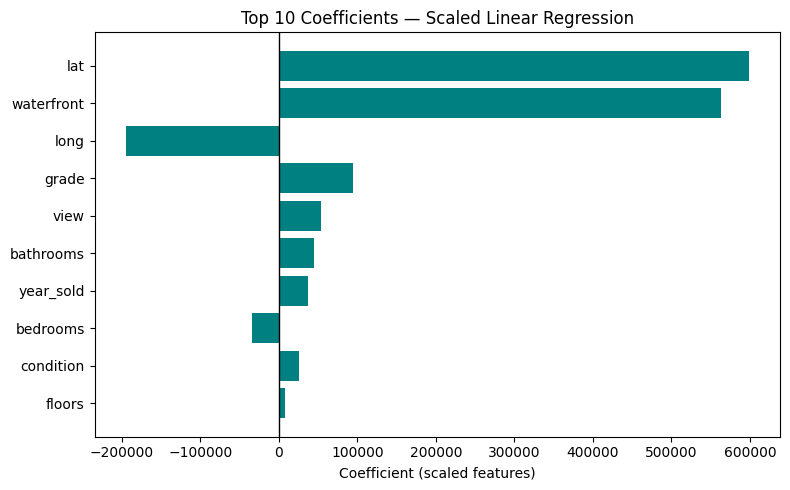

In [164]:
coef_df = pd.DataFrame({
    "feature": features,
    "coefficient": coef
})

# 3. Sort by absolute coefficient and take top 10
coef_df["abs_coef"] = coef_df["coefficient"].abs()
top10 = coef_df.sort_values("abs_coef", ascending=False).head(10)

# 4. Plot
plt.figure(figsize=(8, 5))
plt.barh(top10["feature"][::-1], top10["coefficient"][::-1], color="teal")
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Coefficient (scaled features)")
plt.title("Top 10 Coefficients — Scaled Linear Regression")
plt.tight_layout()
plt.show()

## Effect of Normalization on Linear Regression Feature Importance

In the **unscaled linear regression model**, coefficient magnitudes are heavily influenced by the **units and scale** of each feature. Variables measured on large or arbitrary scales (e.g., longitude, latitude, or binary indicators like `waterfront`) can appear disproportionately important, even if their true relationship with price is weaker. As a result, the top features in the unscaled model reflect a mix of **true predictive power and scaling artifacts**.

After applying **feature normalization (standardization)**, all variables are placed on a comparable scale. In the **scaled linear model**, coefficient magnitudes more accurately represent each feature’s relative influence on price. Under this formulation, **grade**, **living area (`sqft_living`)**, **latitude**, and **above-ground square footage (`sqft_above`)** consistently emerge as the strongest drivers of price.  

This ranking aligns closely with:
- Spearman correlation results  
- Scatter-plot trends from EDA  
- Feature importances from tree-based models  

**Key takeaway:**  
Normalization does not change the model’s predictions, but it **clarifies interpretability**, allowing coefficient magnitudes to reflect genuine feature importance rather than differences in measurement scale.


In [165]:
reduced_features = [
  'bedrooms', 'bathrooms',
    'sqft_living', 'sqft_living15',    # keep this, drop sqft_above
    'sqft_lot',            # keep this, drop sqft_lot15
    'floors', 'waterfront', 'view',
    'condition', 'grade',
    'sqft_basement',
    'yr_built', 'yr_renovated',
    'zipcode', 'lat', 'long',
    'year_sold', 'month_sold', 'day_of_week'
]

# Experiment 3: Removing Redundant Features

In [166]:
# 1. Open a real file on disk to catch the errors
# This gives subprocess access to a real "fileno" (file descriptor)
with open("mcp_debug.log", "w") as log_file:
    
    # 2. Save the original Jupyter stderr (so we can restore it later)
    original_stderr = sys.stderr
    
    try:
        # 3. Redirect stderr to the real file
        sys.stderr = log_file
        
        # 4. Initialize and connect
        # FastMCP will now inherit the "real" file instead of the Jupyter stream
        client = Client("./mcp_utils.py")
        
        async with client:
            tools = await client.list_tools()
            print("Tools found:", [t.name for t in tools])

            result = await client.call_tool(
                "upload_file",
                {"path": "./kc_house_data.csv"}
            )

            print("Upload tool result:", result.structured_content["result"])

            fe_result = await client.call_tool("engineer_features")
            print("Feature Engineering tool result:", fe_result.structured_content["result"])

            # result_dict = data_result.structured_content
            fe_data_result = await client.call_tool("download_fe_data")
            fe_result_dict = fe_data_result.structured_content

            if "result" not in fe_result_dict:
                print("Error: The tool did not return a 'result' key in structured content.")
                print(f"Raw structured content: {fe_result_dict}")
                raise Exception("MCP Tool call failed to return 'result'.")
            
            json_string = fe_result_dict["result"]

            raw_data = json.loads(json_string) 

            data_fe = pd.DataFrame(raw_data) 
            print(f"Feature Engineered Data successfully downloaded. Client-side shape: {data_fe.shape}")


            mod_config = {
                "model_name": "ScaledLinearRegressionWithReducedFeatures",
                "hyperparameters": {}
            }

            train_config = {
                "target_column": "price",
                "test_size": 0.2,
                "random_state": 42
            }

            print("\n--- Running Experiment 3 (Scaled Linear Regression with Reduced Features) ---")
            exp_result = await client.call_tool(
                "run_experiment",
                {
                    "mod_config": mod_config,
                    "train_config": train_config,
                    "feature_list": reduced_features
                }
            )

            run_summary = exp_result.structured_content["result"]

            if run_summary.get("status") == "SUCCESS":
                print(f"Experiment Run ID: {run_summary['run_id']}")
                print(f"   Model: {run_summary['model']}")
                print(f"   Train R²: {run_summary['train_r2']:.4f}")
                print(f"   Train RMSE: {run_summary['train_rmse']:.0f}")
                print(f"   Test R²: {run_summary['test_r2']:.4f}")
                print(f"   Test RMSE: {run_summary['test_rmse']:.0f}")
                print(f"   Test RMSE % Mean: {run_summary['test_rmse_pct_mean']:.2f}%")
                print(f"   Test RMSE % Range: {run_summary['test_rmse_pct_range']:.2f}%")
                print(f"   Training Time (sec): {run_summary['training_time_sec']:.2f}")
            else:
                print(f"Experiment failed: {run_summary.get('error', 'Unknown Error')}")

            run_id = run_summary['run_id']
            print(f"\n--- Retrieving Coefficients for Run ID: {run_id[:8]}... ---")

            coef_result = await client.call_tool(
                "get_model_coefficients",
                {"run_id": run_id}
            )

            coef_data = coef_result.structured_content["result"]

            if isinstance(coef_data, str) and coef_data.startswith("Error:"):
                print(f"Coefficient retrieval failed: {coef_data}")
            else:
                coef = np.array(coef_data["coefficients"])
                print("Coefficient Retrieval Successful")
                features = coef_data["features"]

            set_prod_result = await client.call_tool(
                "set_production_model",
            )

            prod_set_content = set_prod_result.structured_content["result"]

            # --- 3. VERIFY the new Production Model status ---
            print("\n--- Verifying Current Production Status ---")

            get_prod_result = await client.call_tool("get_production_model")
            prod_model_data = get_prod_result.structured_content["result"]

            verified_id = prod_model_data.get("production_run_id")
            verified_summary = prod_model_data.get("summary", {})

            if verified_id:
                print(f"   Best Model Fetch SUCCESSFUL.")
                print(f"   Model Name: {verified_summary.get('model')}")
            else:
                print(f"   VERIFICATION FAILED. Current ID: {verified_id}")
                
                
    except Exception as e:
        print(f"An error occurred: {e}")
        
    finally:
        sys.stderr = original_stderr

# You can inspect the log file afterwards if something goes wrong
# !type mcp_debug.log

Tools found: ['upload_file', 'get_columns_info', 'download_data', 'engineer_features', 'add_features', 'download_fe_data', 'run_experiment', 'get_model_coefficients', 'list_experiments', 'predict_house_price', 'set_production_model', 'get_production_model', 'get_model_list_summary']
Upload tool result: Data successfully loaded. Shape: (21613, 21)
Feature Engineering tool result: Feature Engineering Successful. Shape: (21613, 38)
Feature Engineered Data successfully downloaded. Client-side shape: (21613, 38)

--- Running Experiment 3 (Scaled Linear Regression with Reduced Features) ---
Experiment Run ID: 8efbe28a-6702-4159-9a6a-4266519d7698
   Model: ScaledLinearRegressionWithReducedFeatures
   Train R²: 0.7004
   Train RMSE: 197845
   Test R²: 0.7019
   Test RMSE: 212292
   Test RMSE % Mean: 38.64%
   Test RMSE % Range: 3.87%
   Training Time (sec): 1.20

--- Retrieving Coefficients for Run ID: 8efbe28a... ---
Coefficient Retrieval Successful

--- Verifying Current Production Status --

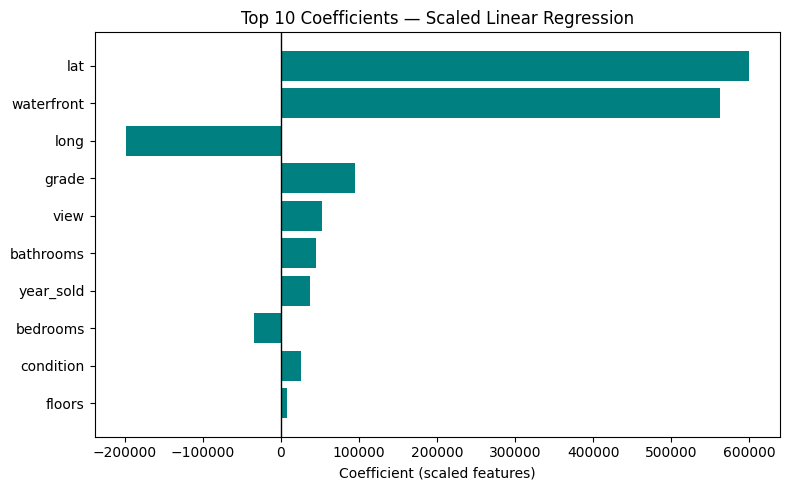

In [167]:
coef_df = pd.DataFrame({
    "feature": features,
    "coefficient": coef
})

# 3. Sort by absolute coefficient and take top 10
coef_df["abs_coef"] = coef_df["coefficient"].abs()
top10 = coef_df.sort_values("abs_coef", ascending=False).head(10)

# 4. Plot
plt.figure(figsize=(8, 5))
plt.barh(top10["feature"][::-1], top10["coefficient"][::-1], color="teal")
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Coefficient (scaled features)")
plt.title("Top 10 Coefficients — Scaled Linear Regression")
plt.tight_layout()
plt.show()

## Baseline Linear Regression Performance

The baseline linear regression model trained on the original feature set achieves **R² ≈ 0.70** with an **RMSE of approximately 3.8% of the price range**. Applying feature scaling does **not** lead to a meaningful change in performance, indicating that the model is **reasonably stable**, not strongly overfitting, and relatively **robust to moderate multicollinearity** among predictors.

These results suggest that further gains are unlikely to come from additional preprocessing or scaling adjustments. Instead, the most promising path forward is **richer feature engineering**—particularly features that better capture non-linear effects, spatial structure, and neighborhood context—rather than further tuning of the baseline linear model.


In [168]:
living_engineered = [
    'total_sqft',
    'living_to_lot_ratio',
    'bath_per_bed',
    'living15_diff',
    'basement_share',
    'has_basement'
]

age_engineered = [
    'house_age',
    'since_renovation',
    'was_renovated',          
]

location_engineered = [
    'lot_per_living'
]

features_full = reduced_features + living_engineered + age_engineered + location_engineered

# Experiment 4: Scaled Linear Regression with all Engineered Features

In [ ]:
# 1. Open a real file on disk to catch the errors
# This gives subprocess access to a real "fileno" (file descriptor)
with open("mcp_debug.log", "w") as log_file:
    
    # 2. Save the original Jupyter stderr (so we can restore it later)
    original_stderr = sys.stderr
    
    try:
        # 3. Redirect stderr to the real file
        sys.stderr = log_file
        
        # 4. Initialize and connect
        # FastMCP will now inherit the "real" file instead of the Jupyter stream
        client = Client("./mcp_utils.py")
        
        async with client:
            tools = await client.list_tools()
            print("Tools found:", [t.name for t in tools])

            result = await client.call_tool(
                "upload_file",
                {"path": "./kc_house_data.csv"}
            )

            print("Upload tool result:", result.structured_content["result"])

            fe_result = await client.call_tool("engineer_features")
            print("Feature Engineering tool result:", fe_result.structured_content["result"])

            # print(f"Feature Engineered Data successfully downloaded. Client-side shape: {data_fe.shape}")
            add_fe_result = await client.call_tool("add_features")
            print("Add Features tool result:", add_fe_result.structured_content["result"])


            mod_config = {
                "model_name": "ScaledLinearRegressionWithAllEngineeredFeatures",
                "hyperparameters": {}
            }

            train_config = {
                "target_column": "price",
                "test_size": 0.2,
                "random_state": 42
            }

            print("\n--- Running Experiment  (Scaled Linear Regression with All Engineered Features) ---")
            exp_result = await client.call_tool(
                "run_experiment",
                {
                    "mod_config": mod_config,
                    "train_config": train_config,
                    "feature_list": features_full
                }
            )

            run_summary = exp_result.structured_content["result"]

            if run_summary.get("status") == "SUCCESS":
                print(f"Experiment Run ID: {run_summary['run_id']}")
                print(f"   Model: {run_summary['model']}")
                print(f"   Train R²: {run_summary['train_r2']:.4f}")
                print(f"   Train RMSE: {run_summary['train_rmse']:.0f}")
                print(f"   Test R²: {run_summary['test_r2']:.4f}")
                print(f"   Test RMSE: {run_summary['test_rmse']:.0f}")
                print(f"   Test RMSE % Mean: {run_summary['test_rmse_pct_mean']:.2f}%")
                print(f"   Test RMSE % Range: {run_summary['test_rmse_pct_range']:.2f}%")
                print(f"   Training Time (sec): {run_summary['training_time_sec']:.2f}")
            else:
                print(f"Experiment failed: {run_summary.get('error', 'Unknown Error')}")

            run_id = run_summary['run_id']
            print(f"\n--- Retrieving Coefficients for Run ID: {run_id[:8]}... ---")

            coef_result = await client.call_tool(
                "get_model_coefficients",
                {"run_id": run_id}
            )

            coef_data = coef_result.structured_content["result"]

            if isinstance(coef_data, str) and coef_data.startswith("Error:"):
                print(f"Coefficient retrieval failed: {coef_data}")
            else:
                coef = np.array(coef_data["coefficients"])
                print("Coefficient Retrieval Successful")
                features = coef_data["features"]
                
            set_prod_result = await client.call_tool(
                "set_production_model",
            )

            prod_set_content = set_prod_result.structured_content["result"]

            # --- 3. VERIFY the new Production Model status ---
            print("\n--- Verifying Current Production Status ---")

            get_prod_result = await client.call_tool("get_production_model")
            prod_model_data = get_prod_result.structured_content["result"]

            verified_id = prod_model_data.get("production_run_id")
            verified_summary = prod_model_data.get("summary", {})

            if verified_id:
                print(f"   Best Model Fetch SUCCESSFUL.")
                print(f"   Model Name: {verified_summary.get('model')}")
            else:
                print(f"   VERIFICATION FAILED. Current ID: {verified_id}")
                
    except Exception as e:
        print(f"An error occurred: {e}")
        
    finally:
        sys.stderr = original_stderr

# You can inspect the log file afterwards if something goes wrong
# !type mcp_debug.log

Tools found: ['upload_file', 'get_columns_info', 'download_data', 'engineer_features', 'add_features', 'download_fe_data', 'run_experiment', 'get_model_coefficients', 'list_experiments', 'predict_house_price', 'set_production_model', 'get_production_model', 'get_model_list_summary']
Upload tool result: Data successfully loaded. Shape: (21613, 21)
Feature Engineering tool result: Feature Engineering Successful. Shape: (21613, 38)
Add Features tool result: Finished Feature Engineering

--- Running Experiment  (Scaled Linear Regression with All Engineered Features) ---
Experiment Run ID: 948de082-7517-4353-a15b-638d05faab8c
   Model: ScaledLinearRegressionWithAllEngineeredFeatures
   Train R²: 0.7138
   Train RMSE: 193378
   Test R²: 0.7129
   Test RMSE: 208349
   Test RMSE % Mean: 37.93%
   Test RMSE % Range: 3.80%
   Training Time (sec): 1.24

--- Retrieving Coefficients for Run ID: 948de082... ---
Coefficient Retrieval Successful

--- Verifying Current Production Status ---
   Best Mod

# Experiment 5: Ridge Regression

In [ ]:
# 1. Open a real file on disk to catch the errors
# This gives subprocess access to a real "fileno" (file descriptor)
with open("mcp_debug.log", "w") as log_file:
    
    # 2. Save the original Jupyter stderr (so we can restore it later)
    original_stderr = sys.stderr
    
    try:
        # 3. Redirect stderr to the real file
        sys.stderr = log_file
        
        # 4. Initialize and connect
        # FastMCP will now inherit the "real" file instead of the Jupyter stream
        client = Client("./mcp_utils.py")
        
        async with client:
            tools = await client.list_tools()
            print("Tools found:", [t.name for t in tools])

            result = await client.call_tool(
                "upload_file",
                {"path": "./kc_house_data.csv"}
            )

            print("Upload tool result:", result.structured_content["result"])

            fe_result = await client.call_tool("engineer_features")
            print("Feature Engineering tool result:", fe_result.structured_content["result"])

            add_fe_result = await client.call_tool("add_features")
            print("Add Features tool result:", add_fe_result.structured_content["result"])


            mod_config = {
                "model_name": "Ridge",
                "hyperparameters": {
                    'ridge__alpha': [0.01, 0.1, 1, 10, 50, 100, 200, 500, 1000, 2000, 5000]
                }
            }

            train_config = {
                "target_column": "price",
                "test_size": 0.2,
                "random_state": 42
            }

            print("\n--- Running Experiment  (Scaled Ridge Regression with alpha grid search) ---")
            exp_result = await client.call_tool(
                "run_experiment",
                {
                    "mod_config": mod_config,
                    "train_config": train_config,
                    "feature_list": features_full
                }
            )

            run_summary = exp_result.structured_content["result"]

            if run_summary.get("status") == "SUCCESS":
                print(f"Experiment Run ID: {run_summary['run_id']}")
                print(f"   Model: {run_summary['model']}")
                print(f"   Train R²: {run_summary['train_r2']:.4f}")
                print(f"   Train RMSE: {run_summary['train_rmse']:.0f}")
                print(f"   Test R²: {run_summary['test_r2']:.4f}")
                print(f"   Test RMSE: {run_summary['test_rmse']:.0f}")
                print(f"   Test RMSE % Mean: {run_summary['test_rmse_pct_mean']:.2f}%")
                print(f"   Test RMSE % Range: {run_summary['test_rmse_pct_range']:.2f}%")
                print(f"   Training Time (sec): {run_summary['training_time_sec']:.2f}")
                print(f"   Best Param: {run_summary['best_param']['ridge__alpha']:.4f}")
            else:
                print(f"Experiment failed: {run_summary.get('error', 'Unknown Error')}")

            run_id = run_summary['run_id']
            print(f"\n--- Retrieving Coefficients for Run ID: {run_id[:8]}... ---")

            coef_result = await client.call_tool(
                "get_model_coefficients",
                {"run_id": run_id}
            )

            coef_data = coef_result.structured_content["result"]

            if isinstance(coef_data, str) and coef_data.startswith("Error:"):
                print(f"Coefficient retrieval failed: {coef_data}")
            else:
                coef = np.array(coef_data["coefficients"])
                print("Coefficient Retrieval Successful")
                features = coef_data["features"]
            set_prod_result = await client.call_tool(
                "set_production_model",
            )

            prod_set_content = set_prod_result.structured_content["result"]

            # --- 3. VERIFY the new Production Model status ---
            print("\n--- Verifying Current Production Status ---")

            get_prod_result = await client.call_tool("get_production_model")
            prod_model_data = get_prod_result.structured_content["result"]

            verified_id = prod_model_data.get("production_run_id")
            verified_summary = prod_model_data.get("summary", {})

            if verified_id:
                print(f"   Best Model Fetch SUCCESSFUL.")
                print(f"   Model Name: {verified_summary.get('model')}")
            else:
                print(f"   VERIFICATION FAILED. Current ID: {verified_id}")
                
                
    except Exception as e:
        print(f"An error occurred: {e}")
        
    finally:
        sys.stderr = original_stderr

# You can inspect the log file afterwards if something goes wrong
# !type mcp_debug.log

Tools found: ['upload_file', 'get_columns_info', 'download_data', 'engineer_features', 'add_features', 'download_fe_data', 'run_experiment', 'get_model_coefficients', 'list_experiments', 'predict_house_price', 'set_production_model', 'get_production_model', 'get_model_list_summary']
Upload tool result: Data successfully loaded. Shape: (21613, 21)
Feature Engineering tool result: Feature Engineering Successful. Shape: (21613, 38)
Add Features tool result: Finished Feature Engineering

--- Running Experiment  (Scaled Ridge Regression with alpha grid search) ---
Experiment Run ID: 98646b4c-609c-4c6a-8959-6706ba7630ab
   Model: Ridge
   Train R²: 0.7138
   Train RMSE: 193379
   Test R²: 0.7128
   Test RMSE: 208357
   Test RMSE % Mean: 37.93%
   Test RMSE % Range: 3.80%
   Training Time (sec): 1.78
   Best Param: 0.0100

--- Retrieving Coefficients for Run ID: 98646b4c... ---
Coefficient Retrieval Successful

--- Verifying Current Production Status ---
   Best Model Fetch SUCCESSFUL.
   Mod

In [171]:
ridge_coefs = pd.DataFrame({
    'feature': features,
    'coefficient': coef
})
ridge_coefs['abs_coef'] = ridge_coefs['coefficient'].abs()
ridge_coefs = ridge_coefs.sort_values('abs_coef', ascending=False)

print("\n Top 20 Ridge Features (by absolute coefficient):")
print(ridge_coefs.head(20).to_string(index=False))


 Top 20 Ridge Features (by absolute coefficient):
            feature   coefficient     abs_coef
       yr_renovated  1.536801e+06 1.536801e+06
      was_renovated -1.514932e+06 1.514932e+06
     basement_share -1.417940e+05 1.417940e+05
              grade  1.088724e+05 1.088724e+05
                lat  8.137777e+04 8.137777e+04
          bathrooms  6.735010e+04 6.735010e+04
       has_basement  6.692453e+04 6.692453e+04
         total_sqft  5.929285e+04 5.929285e+04
        sqft_living  5.821968e+04 5.821968e+04
      sqft_living15  5.285348e+04 5.285348e+04
           bedrooms -5.085001e+04 5.085001e+04
         waterfront  4.885623e+04 4.885623e+04
      sqft_basement  3.699188e+04 3.699188e+04
               view  3.656507e+04 3.656507e+04
   since_renovation  3.571410e+04 3.571410e+04
       bath_per_bed -3.252584e+04 3.252584e+04
            zipcode -2.920359e+04 2.920359e+04
living_to_lot_ratio  2.886659e+04 2.886659e+04
      living15_diff  2.826163e+04 2.826163e+04
         

# Experiment 6: Lasso Regression

In [172]:
# 1. Open a real file on disk to catch the errors
# This gives subprocess access to a real "fileno" (file descriptor)
with open("mcp_debug.log", "w") as log_file:
    
    # 2. Save the original Jupyter stderr (so we can restore it later)
    original_stderr = sys.stderr
    
    try:
        # 3. Redirect stderr to the real file
        sys.stderr = log_file
        
        # 4. Initialize and connect
        # FastMCP will now inherit the "real" file instead of the Jupyter stream
        client = Client("./mcp_utils.py")
        
        async with client:
            tools = await client.list_tools()
            print("Tools found:", [t.name for t in tools])

            result = await client.call_tool(
                "upload_file",
                {"path": "./kc_house_data.csv"}
            )

            print("Upload tool result:", result.structured_content["result"])

            fe_result = await client.call_tool("engineer_features")
            print("Feature Engineering tool result:", fe_result.structured_content["result"])

            add_fe_result = await client.call_tool("add_features")
            print("Add Features tool result:", add_fe_result.structured_content["result"])


            mod_config = {
                "model_name": "Lasso",
                "hyperparameters": {
                    'lasso__alpha': [0.1, 1, 10, 50, 100, 500, 1000, 2000, 5000, 10000]
                }
            }

            train_config = {
                "target_column": "price",
                "test_size": 0.2,
                "random_state": 42
            }

            print("\n--- Running Experiment  (Scaled Lasso Regression with alpha grid search) ---")
            exp_result = await client.call_tool(
                "run_experiment",
                {
                    "mod_config": mod_config,
                    "train_config": train_config,
                    "feature_list": features_full
                }
            )

            run_summary = exp_result.structured_content["result"]

            if run_summary.get("status") == "SUCCESS":
                print(f"Experiment Run ID: {run_summary['run_id']}")
                print(f"   Model: {run_summary['model']}")
                print(f"   Train R²: {run_summary['train_r2']:.4f}")
                print(f"   Train RMSE: {run_summary['train_rmse']:.0f}")
                print(f"   Test R²: {run_summary['test_r2']:.4f}")
                print(f"   Test RMSE: {run_summary['test_rmse']:.0f}")
                print(f"   Test RMSE % Mean: {run_summary['test_rmse_pct_mean']:.2f}%")
                print(f"   Test RMSE % Range: {run_summary['test_rmse_pct_range']:.2f}%")
                print(f"   Training Time (sec): {run_summary['training_time_sec']:.2f}")
                print(f"   Best Param: {run_summary['best_param']['lasso__alpha']:.4f}")
                
            else:
                print(f"Experiment failed: {run_summary.get('error', 'Unknown Error')}")

            run_id = run_summary['run_id']
            print(f"\n--- Retrieving Coefficients for Run ID: {run_id[:8]}... ---")

            coef_result = await client.call_tool(
                "get_model_coefficients",
                {"run_id": run_id}
            )

            coef_data = coef_result.structured_content["result"]

            if isinstance(coef_data, str) and coef_data.startswith("Error:"):
                print(f"Coefficient retrieval failed: {coef_data}")
            else:
                coef = np.array(coef_data["coefficients"])
                print("Coefficient Retrieval Successful")
                features = coef_data["features"]
            set_prod_result = await client.call_tool(
                "set_production_model",
            )

            prod_set_content = set_prod_result.structured_content["result"]

            # --- 3. VERIFY the new Production Model status ---
            print("\n--- Verifying Current Production Status ---")

            get_prod_result = await client.call_tool("get_production_model")
            prod_model_data = get_prod_result.structured_content["result"]

            verified_id = prod_model_data.get("production_run_id")
            verified_summary = prod_model_data.get("summary", {})

            if verified_id:
                print(f"   Best Model Fetch SUCCESSFUL.")
                print(f"   Model Name: {verified_summary.get('model')}")
            else:
                print(f"   VERIFICATION FAILED. Current ID: {verified_id}")
                
                
    except Exception as e:
        print(f"An error occurred: {e}")
        
    finally:
        sys.stderr = original_stderr

# You can inspect the log file afterwards if something goes wrong
# !type mcp_debug.log

Tools found: ['upload_file', 'get_columns_info', 'download_data', 'engineer_features', 'add_features', 'download_fe_data', 'run_experiment', 'get_model_coefficients', 'list_experiments', 'predict_house_price', 'set_production_model', 'get_production_model', 'get_model_list_summary']
Upload tool result: Data successfully loaded. Shape: (21613, 21)
Feature Engineering tool result: Feature Engineering Successful. Shape: (21613, 38)
Add Features tool result: Finished Feature Engineering

--- Running Experiment  (Scaled Lasso Regression with alpha grid search) ---
Experiment Run ID: 547a23bb-7252-4454-84e5-01bdfcc3e70a
   Model: Lasso
   Train R²: 0.7125
   Train RMSE: 193796
   Test R²: 0.7107
   Test RMSE: 209145
   Test RMSE % Mean: 38.07%
   Test RMSE % Range: 3.81%
   Training Time (sec): 7.98
   Best Param: 500.0000

--- Retrieving Coefficients for Run ID: 547a23bb... ---
Coefficient Retrieval Successful

--- Verifying Current Production Status ---
   Best Model Fetch SUCCESSFUL.
   M

In [173]:
lasso_coefs = pd.DataFrame({
    'feature': features,
    'coefficient': coef
})
lasso_coefs['abs_coef'] = lasso_coefs['coefficient'].abs()
lasso_coefs = lasso_coefs.sort_values('abs_coef', ascending=False)

print("\n Top 20 Lasso Features (by absolute coefficient):")
print(lasso_coefs.head(20).to_string(index=False))

# Count non-zero coefficients (Lasso feature selection)
n_nonzero = (lasso_coefs['coefficient'] != 0).sum()
print(f"\n Number of non-zero coefficients: {n_nonzero} out of {len(features_full)}")

# Features eliminated by Lasso
eliminated = lasso_coefs[lasso_coefs['coefficient'] == 0]['feature'].tolist()
if eliminated:
    print(f"Features eliminated by Lasso: {eliminated}")
else:
    print("Lasso kept all features (no elimination)")


 Top 20 Lasso Features (by absolute coefficient):
            feature    coefficient      abs_coef
         total_sqft  141591.893562 141591.893562
     basement_share -125901.037652 125901.037652
              grade  109289.562573 109289.562573
                lat   80916.065325  80916.065325
          house_age   64276.312999  64276.312999
       has_basement   57399.971510  57399.971510
          bathrooms   56287.218793  56287.218793
         waterfront   48270.484747  48270.484747
           bedrooms  -42929.845469  42929.845469
        sqft_living   38048.960345  38048.960345
               view   36734.954368  36734.954368
            zipcode  -27797.549176  27797.549176
living_to_lot_ratio   26686.983280  26686.983280
       bath_per_bed  -23330.143466  23330.143466
               long  -22972.879450  22972.879450
      sqft_living15   19709.565578  19709.565578
          condition   17968.417000  17968.417000
           yr_built  -15080.311132  15080.311132
             floor

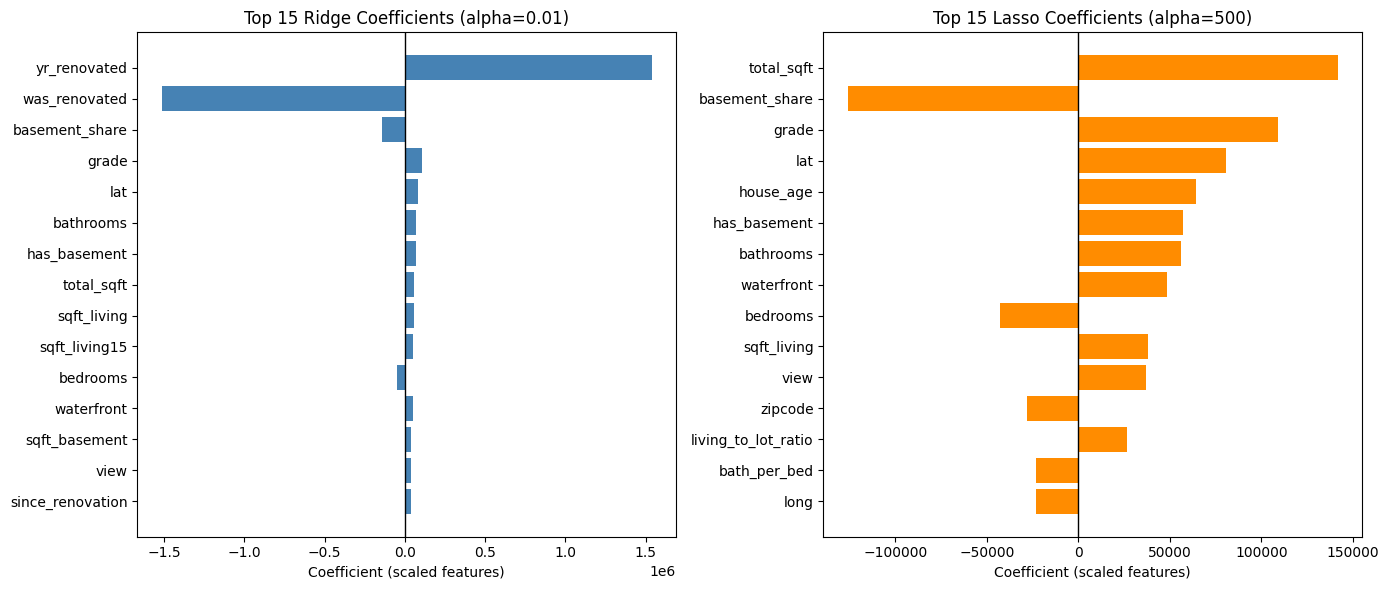

In [174]:
# Visualization
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Ridge top 15
ridge_top15 = ridge_coefs.head(15)
axes[0].barh(ridge_top15['feature'][::-1], ridge_top15['coefficient'][::-1], color='steelblue')
axes[0].axvline(0, color='black', linewidth=1)
axes[0].set_xlabel('Coefficient (scaled features)')
axes[0].set_title(f'Top 15 Ridge Coefficients (alpha=0.01)')

# Lasso top 15
lasso_top15 = lasso_coefs.head(15)
axes[1].barh(lasso_top15['feature'][::-1], lasso_top15['coefficient'][::-1], color='darkorange')
axes[1].axvline(0, color='black', linewidth=1)
axes[1].set_xlabel('Coefficient (scaled features)')
axes[1].set_title(f'Top 15 Lasso Coefficients (alpha=500)')

plt.tight_layout()
plt.show()

# Experiment 7: Random Forest with all Features

In [175]:
# 1. Open a real file on disk to catch the errors
# This gives subprocess access to a real "fileno" (file descriptor)
with open("mcp_debug.log", "w") as log_file:
    
    # 2. Save the original Jupyter stderr (so we can restore it later)
    original_stderr = sys.stderr
    
    try:
        # 3. Redirect stderr to the real file
        sys.stderr = log_file
        
        # 4. Initialize and connect
        # FastMCP will now inherit the "real" file instead of the Jupyter stream
        client = Client("./mcp_utils.py")
        
        async with client:
            tools = await client.list_tools()
            print("Tools found:", [t.name for t in tools])

            result = await client.call_tool(
                "upload_file",
                {"path": "./kc_house_data.csv"}
            )

            print("Upload tool result:", result.structured_content["result"])

            fe_result = await client.call_tool("engineer_features")
            print("Feature Engineering tool result:", fe_result.structured_content["result"])

            add_fe_result = await client.call_tool("add_features")
            print("Add Features tool result:", add_fe_result.structured_content["result"])

            mod_config = {
                "model_name": "RandomForest",
                "hyperparameters": {
                    'n_estimators': [200],
                    'max_depth': [None],
                    'random_state': [42],
                    'n_jobs': [-1],
                }
            }

            train_config = {
                "target_column": "price",
                "test_size": 0.2,
                "random_state": 42
            }

            print("\n--- Running Experiment  (Random Forest) ---")
            exp_result = await client.call_tool(
                "run_experiment",
                {
                    "mod_config": mod_config,
                    "train_config": train_config,
                    "feature_list": features_full
                }
            )

            run_summary = exp_result.structured_content["result"]

            if run_summary.get("status") == "SUCCESS":
                print(f"Experiment Run ID: {run_summary['run_id']}")
                print(f"   Model: {run_summary['model']}")
                print(f"   Train R²: {run_summary['train_r2']:.4f}")
                print(f"   Train RMSE: {run_summary['train_rmse']:.0f}")
                print(f"   Test R²: {run_summary['test_r2']:.4f}")
                print(f"   Test RMSE: {run_summary['test_rmse']:.0f}")
                print(f"   Test RMSE % Mean: {run_summary['test_rmse_pct_mean']:.2f}%")
                print(f"   Test RMSE % Range: {run_summary['test_rmse_pct_range']:.2f}%")
                print(f"   Training Time (sec): {run_summary['training_time_sec']:.2f}")
                # print(f"   Best Param: {run_summary['best_param']['lasso__alpha']:.4f}")
                
            else:
                print(f"Experiment failed: {run_summary.get('error', 'Unknown Error')}")
            
            set_prod_result = await client.call_tool(
                "set_production_model",
            )

            prod_set_content = set_prod_result.structured_content["result"]

            # --- 3. VERIFY the new Production Model status ---
            print("\n--- Verifying Current Production Status ---")

            get_prod_result = await client.call_tool("get_production_model")
            prod_model_data = get_prod_result.structured_content["result"]

            verified_id = prod_model_data.get("production_run_id")
            verified_summary = prod_model_data.get("summary", {})

            if verified_id:
                print(f"   Best Model Fetch SUCCESSFUL.")
                print(f"   Model Name: {verified_summary.get('model')}")
            else:
                print(f"   VERIFICATION FAILED. Current ID: {verified_id}")
                
                
    except Exception as e:
        print(f"An error occurred: {e}")
        
    finally:
        sys.stderr = original_stderr

# You can inspect the log file afterwards if something goes wrong
# !type mcp_debug.log

Tools found: ['upload_file', 'get_columns_info', 'download_data', 'engineer_features', 'add_features', 'download_fe_data', 'run_experiment', 'get_model_coefficients', 'list_experiments', 'predict_house_price', 'set_production_model', 'get_production_model', 'get_model_list_summary']
Upload tool result: Data successfully loaded. Shape: (21613, 21)
Feature Engineering tool result: Feature Engineering Successful. Shape: (21613, 38)
Add Features tool result: Finished Feature Engineering

--- Running Experiment  (Random Forest) ---
Experiment Run ID: 6ea3677a-e642-4b61-8f3b-5d22491e674a
   Model: RandomForest
   Train R²: 0.9828
   Train RMSE: 47455
   Test R²: 0.8452
   Test RMSE: 152962
   Test RMSE % Mean: 27.84%
   Test RMSE % Range: 2.79%
   Training Time (sec): 17.63

--- Verifying Current Production Status ---
   Best Model Fetch SUCCESSFUL.
   Model Name: RandomForest


In [176]:
# Trying reducing redundant features
rf_features = [
    # size & quality
    'sqft_living', 'total_sqft', 'sqft_living15',
    'bathrooms', 'bedrooms', 'grade', 'view',
    'sqft_basement',

    # lot / density
    'sqft_lot', 'living15_diff', 'lot_per_living',

    # location
    'lat', 'long', 'zipcode',

    # age / renovation
    'house_age', 'since_renovation', 'was_renovated',

    # others you think are clearly meaningful
    'waterfront', 'floors'
]

# Experiment 8: Random Forest with Reduced Features

In [178]:
# 1. Open a real file on disk to catch the errors
# This gives subprocess access to a real "fileno" (file descriptor)
with open("mcp_debug.log", "w") as log_file:
    
    # 2. Save the original Jupyter stderr (so we can restore it later)
    original_stderr = sys.stderr
    
    try:
        # 3. Redirect stderr to the real file
        sys.stderr = log_file
        
        # 4. Initialize and connect
        # FastMCP will now inherit the "real" file instead of the Jupyter stream
        client = Client("./mcp_utils.py")
        
        async with client:
            tools = await client.list_tools()
            print("Tools found:", [t.name for t in tools])

            result = await client.call_tool(
                "upload_file",
                {"path": "./kc_house_data.csv"}
            )

            print("Upload tool result:", result.structured_content["result"])

            fe_result = await client.call_tool("engineer_features")
            print("Feature Engineering tool result:", fe_result.structured_content["result"])

            add_fe_result = await client.call_tool("add_features")
            print("Add Features tool result:", add_fe_result.structured_content["result"])

            mod_config = {
                "model_name": "RandomForestWithReducedFeatures",
                "hyperparameters": {
                    'n_estimators': [300],
                    'max_depth': [10],
                    'min_samples_leaf': [8],
                    'min_samples_split': [20],
                    'max_features': ['sqrt'],
                    'random_state': [42],
                    'n_jobs': [-1],
                }
            }

            train_config = {
                "target_column": "price",
                "test_size": 0.2,
                "random_state": 42
            }

            print("\n--- Running Experiment  (Random Forest with Reduced Features) ---")
            exp_result = await client.call_tool(
                "run_experiment",
                {
                    "mod_config": mod_config,
                    "train_config": train_config,
                    "feature_list": rf_features
                }
            )

            run_summary = exp_result.structured_content["result"]

            if run_summary.get("status") == "SUCCESS":
                print(f"Experiment Run ID: {run_summary['run_id']}")
                print(f"   Model: {run_summary['model']}")
                print(f"   Train R²: {run_summary['train_r2']:.4f}")
                print(f"   Train RMSE: {run_summary['train_rmse']:.0f}")
                print(f"   Test R²: {run_summary['test_r2']:.4f}")
                print(f"   Test RMSE: {run_summary['test_rmse']:.0f}")
                print(f"   Test RMSE % Mean: {run_summary['test_rmse_pct_mean']:.2f}%")
                print(f"   Test RMSE % Range: {run_summary['test_rmse_pct_range']:.2f}%")
                print(f"   Training Time (sec): {run_summary['training_time_sec']:.2f}")
                # print(f"   Best Param: {run_summary['best_param']['lasso__alpha']:.4f}")
                
            else:
                print(f"Experiment failed: {run_summary.get('error', 'Unknown Error')}")

            set_prod_result = await client.call_tool(
                "set_production_model",
            )

            prod_set_content = set_prod_result.structured_content["result"]

            # --- 3. VERIFY the new Production Model status ---
            print("\n--- Verifying Current Production Status ---")

            get_prod_result = await client.call_tool("get_production_model")
            prod_model_data = get_prod_result.structured_content["result"]

            verified_id = prod_model_data.get("production_run_id")
            verified_summary = prod_model_data.get("summary", {})

            if verified_id:
                print(f"   Best Model Fetch SUCCESSFUL.")
                print(f"   Model Name: {verified_summary.get('model')}")
            else:
                print(f"   VERIFICATION FAILED. Current ID: {verified_id}")
                
                
    except Exception as e:
        print(f"An error occurred: {e}")
        
    finally:
        sys.stderr = original_stderr

# You can inspect the log file afterwards if something goes wrong
# !type mcp_debug.log

Tools found: ['upload_file', 'get_columns_info', 'download_data', 'engineer_features', 'add_features', 'download_fe_data', 'run_experiment', 'get_model_coefficients', 'list_experiments', 'predict_house_price', 'set_production_model', 'get_production_model', 'get_model_list_summary']
Upload tool result: Data successfully loaded. Shape: (21613, 21)
Feature Engineering tool result: Feature Engineering Successful. Shape: (21613, 38)
Add Features tool result: Finished Feature Engineering

--- Running Experiment  (Random Forest with Reduced Features) ---
Experiment Run ID: f3be85b3-7cb5-4938-9d06-89bd66612b16
   Model: RandomForestWithReducedFeatures
   Train R²: 0.8651
   Train RMSE: 132780
   Test R²: 0.8203
   Test RMSE: 164841
   Test RMSE % Mean: 30.01%
   Test RMSE % Range: 3.00%
   Training Time (sec): 4.27

--- Verifying Current Production Status ---
   Best Model Fetch SUCCESSFUL.
   Model Name: RandomForest


# Experiment 9: XGBoost Regressor

In [179]:
# 1. Open a real file on disk to catch the errors
# This gives subprocess access to a real "fileno" (file descriptor)
with open("mcp_debug.log", "w") as log_file:
    
    # 2. Save the original Jupyter stderr (so we can restore it later)
    original_stderr = sys.stderr
    
    try:
        # 3. Redirect stderr to the real file
        sys.stderr = log_file
        
        # 4. Initialize and connect
        # FastMCP will now inherit the "real" file instead of the Jupyter stream
        client = Client("./mcp_utils.py")
        
        async with client:
            tools = await client.list_tools()
            print("Tools found:", [t.name for t in tools])

            result = await client.call_tool(
                "upload_file",
                {"path": "./kc_house_data.csv"}
            )

            print("Upload tool result:", result.structured_content["result"])

            fe_result = await client.call_tool("engineer_features")
            print("Feature Engineering tool result:", fe_result.structured_content["result"])

            add_fe_result = await client.call_tool("add_features")
            print("Add Features tool result:", add_fe_result.structured_content["result"])

            mod_config = {
                "model_name": "XGBoost",
                "hyperparameters": {
                    'n_estimators': [400],
                    'learning_rate': [0.05],
                    'max_depth': [4],
                    'subsample': [0.8],
                    'colsample_bytree': [0.8],
                    'reg_lambda': [1.0],
                    'reg_alpha': [0.0],
                    'objective': ["reg:squarederror"],
                    'random_state': [42],
                    'n_jobs': [-1]
                }
            }

            train_config = {
                "target_column": "price",
                "test_size": 0.2,
                "random_state": 42
            }

            print("\n--- Running Experiment  (XGBoost with Full Features) ---")
            exp_result = await client.call_tool(
                "run_experiment",
                {
                    "mod_config": mod_config,
                    "train_config": train_config,
                    "feature_list": features_full
                }
            )

            run_summary = exp_result.structured_content["result"]

            if run_summary.get("status") == "SUCCESS":
                print(f"Experiment Run ID: {run_summary['run_id']}")
                print(f"   Model: {run_summary['model']}")
                print(f"   Train R²: {run_summary['train_r2']:.4f}")
                print(f"   Train RMSE: {run_summary['train_rmse']:.0f}")
                print(f"   Test R²: {run_summary['test_r2']:.4f}")
                print(f"   Test RMSE: {run_summary['test_rmse']:.0f}")
                print(f"   Test RMSE % Mean: {run_summary['test_rmse_pct_mean']:.2f}%")
                print(f"   Test RMSE % Range: {run_summary['test_rmse_pct_range']:.2f}%")
                print(f"   Training Time (sec): {run_summary['training_time_sec']:.2f}")
                # print(f"   Best Param: {run_summary['best_param']['lasso__alpha']:.4f}")
                
            else:
                print(f"Experiment failed: {run_summary.get('error', 'Unknown Error')}")

            set_prod_result = await client.call_tool(
                "set_production_model",
            )

            prod_set_content = set_prod_result.structured_content["result"]

            # --- 3. VERIFY the new Production Model status ---
            print("\n--- Verifying Current Production Status ---")

            get_prod_result = await client.call_tool("get_production_model")
            prod_model_data = get_prod_result.structured_content["result"]

            verified_id = prod_model_data.get("production_run_id")
            verified_summary = prod_model_data.get("summary", {})

            if verified_id:
                print(f"   Best Model Fetch SUCCESSFUL.")
                print(f"   Model Name: {verified_summary.get('model')}")
            else:
                print(f"   VERIFICATION FAILED. Current ID: {verified_id}")
                
                
    except Exception as e:
        print(f"An error occurred: {e}")
        
    finally:
        sys.stderr = original_stderr

# You can inspect the log file afterwards if something goes wrong
# !type mcp_debug.log

Tools found: ['upload_file', 'get_columns_info', 'download_data', 'engineer_features', 'add_features', 'download_fe_data', 'run_experiment', 'get_model_coefficients', 'list_experiments', 'predict_house_price', 'set_production_model', 'get_production_model', 'get_model_list_summary']
Upload tool result: Data successfully loaded. Shape: (21613, 21)
Feature Engineering tool result: Feature Engineering Successful. Shape: (21613, 38)
Add Features tool result: Finished Feature Engineering

--- Running Experiment  (XGBoost with Full Features) ---
Experiment Run ID: 40462f6d-2450-4acc-91b0-3ca38421da95
   Model: XGBoost
   Train R²: 0.9428
   Train RMSE: 86430
   Test R²: 0.8617
   Test RMSE: 144605
   Test RMSE % Mean: 26.32%
   Test RMSE % Range: 2.64%
   Training Time (sec): 2.06

--- Verifying Current Production Status ---
   Best Model Fetch SUCCESSFUL.
   Model Name: XGBoost


# Experiment 10: Regularized XGBoost Regressor

In [180]:
# 1. Open a real file on disk to catch the errors
# This gives subprocess access to a real "fileno" (file descriptor)
with open("mcp_debug.log", "w") as log_file:
    
    # 2. Save the original Jupyter stderr (so we can restore it later)
    original_stderr = sys.stderr
    
    try:
        # 3. Redirect stderr to the real file
        sys.stderr = log_file
        
        # 4. Initialize and connect
        # FastMCP will now inherit the "real" file instead of the Jupyter stream
        client = Client("./mcp_utils.py")
        
        async with client:
            tools = await client.list_tools()
            print("Tools found:", [t.name for t in tools])

            result = await client.call_tool(
                "upload_file",
                {"path": "./kc_house_data.csv"}
            )

            print("Upload tool result:", result.structured_content["result"])

            fe_result = await client.call_tool("engineer_features")
            print("Feature Engineering tool result:", fe_result.structured_content["result"])

            add_fe_result = await client.call_tool("add_features")
            print("Add Features tool result:", add_fe_result.structured_content["result"])

            mod_config = {
                "model_name": "XGBoostWithReg",
                "hyperparameters": {
                    'n_estimators': [300],
                    'max_depth': [5],
                    'learning_rate': [0.05],
                    'subsample': [0.7],
                    'colsample_bytree': [0.7],
                    'reg_alpha': [1],
                    'reg_lambda': [10],
                    'min_child_weight': [3],
                    'random_state': [42],
                    'n_jobs': [-1]
                }
            }

            train_config = {
                "target_column": "price",
                "test_size": 0.2,
                "random_state": 42
            }

            print("\n--- Running Experiment  (Regularized XGBoost) ---")
            exp_result = await client.call_tool(
                "run_experiment",
                {
                    "mod_config": mod_config,
                    "train_config": train_config,
                    "feature_list": features_full
                }
            )

            run_summary = exp_result.structured_content["result"]

            if run_summary.get("status") == "SUCCESS":
                print(f"Experiment Run ID: {run_summary['run_id']}")
                print(f"   Model: {run_summary['model']}")
                print(f"   Train R²: {run_summary['train_r2']:.4f}")
                print(f"   Train RMSE: {run_summary['train_rmse']:.0f}")
                print(f"   Test R²: {run_summary['test_r2']:.4f}")
                print(f"   Test RMSE: {run_summary['test_rmse']:.0f}")
                print(f"   Test RMSE % Mean: {run_summary['test_rmse_pct_mean']:.2f}%")
                print(f"   Test RMSE % Range: {run_summary['test_rmse_pct_range']:.2f}%")
                print(f"   Training Time (sec): {run_summary['training_time_sec']:.2f}")
                # print(f"   Best Param: {run_summary['best_param']['lasso__alpha']:.4f}")
                
            else:
                print(f"Experiment failed: {run_summary.get('error', 'Unknown Error')}")

            set_prod_result = await client.call_tool(
                "set_production_model",
            )

            prod_set_content = set_prod_result.structured_content["result"]

            # --- 3. VERIFY the new Production Model status ---
            print("\n--- Verifying Current Production Status ---")

            get_prod_result = await client.call_tool("get_production_model")
            prod_model_data = get_prod_result.structured_content["result"]

            verified_id = prod_model_data.get("production_run_id")
            verified_summary = prod_model_data.get("summary", {})

            if verified_id:
                print(f"   Best Model Fetch SUCCESSFUL.")
                print(f"   Model Name: {verified_summary.get('model')}")
            else:
                print(f"   VERIFICATION FAILED. Current ID: {verified_id}")
                
                
    except Exception as e:
        print(f"An error occurred: {e}")
        
    finally:
        sys.stderr = original_stderr

# You can inspect the log file afterwards if something goes wrong
# !type mcp_debug.log

Tools found: ['upload_file', 'get_columns_info', 'download_data', 'engineer_features', 'add_features', 'download_fe_data', 'run_experiment', 'get_model_coefficients', 'list_experiments', 'predict_house_price', 'set_production_model', 'get_production_model', 'get_model_list_summary']
Upload tool result: Data successfully loaded. Shape: (21613, 21)
Feature Engineering tool result: Feature Engineering Successful. Shape: (21613, 38)
Add Features tool result: Finished Feature Engineering

--- Running Experiment  (Regularized XGBoost) ---
Experiment Run ID: 31240d5a-08d9-4979-92a9-3d1e05e59e14
   Model: XGBoostWithReg
   Train R²: 0.9377
   Train RMSE: 90188
   Test R²: 0.8711
   Test RMSE: 139584
   Test RMSE % Mean: 25.41%
   Test RMSE % Range: 2.54%
   Training Time (sec): 1.91

--- Verifying Current Production Status ---
   Best Model Fetch SUCCESSFUL.
   Model Name: XGBoostWithReg


In [181]:
import json
import pandas as pd

# Load JSON
with open("artifacts/registry.json", "r") as f:
    registry = json.load(f)

rows = []
for entry in registry:
    row = {
        "model_name": entry["model_config"]["model_name"],
        **entry["metrics"]  # unpack all metrics
    }
    rows.append(row)

df = pd.DataFrame(rows)
df = df.sort_values("test_r2", ascending=False)
df = df.drop(columns=["best_param"])
df.round(4)

,model_name,train_r2,train_rmse,test_r2,test_rmse,test_rmse_pct_mean,test_rmse_pct_range,train_time_sec
9,XGBoostWithReg,0.9377,90187.6840,0.8711,139583.6638,25.4081,2.5437,1.9118
8,XGBoost,0.9428,86429.6175,0.8617,144605.0015,26.3221,2.6352,2.0606
6,RandomForest,0.9828,47454.6245,0.8452,152962.0801,27.8433,2.7875,17.6251
7,RandomForestWithReducedFeatures,0.8651,132779.6960,0.8203,164840.8289,30.0056,3.0039,4.2727
3,ScaledLinearRegressionWithAllEngineeredFeatures,0.7138,193378.3481,0.7129,208349.1444,37.9253,3.7968,1.2366
4,Ridge,0.7138,193378.5080,0.7128,208357.0124,37.9267,3.7969,1.7764
5,Lasso,0.7125,193795.5499,0.7107,209145.1528,38.0702,3.8113,7.9822
0,LinearRegression,0.7007,197752.5569,0.7026,212039.6152,38.5970,3.8640,1.1614
1,ScaledLinearRegression,0.7007,197752.5569,0.7026,212039.6152,38.5970,3.8640,1.1821
2,ScaledLinearRegressionWithReducedFeatures,0.7004,197844.8456,0.7019,212291.7320,38.6429,3.8686,1.2025


In [182]:
# Overfitting gap
df["overfit_gap"] = df["train_r2"] - df["test_r2"]

print("=" * 100)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 100)
print(
    df[
        ["model_name", "train_r2", "test_r2",
         "train_rmse", "test_rmse", "test_rmse_pct_mean", "overfit_gap"]
    ].to_string(index=False)
)

print("\n" + "=" * 100)
print("KEY METRICS SUMMARY")
print("=" * 100)

best_r2_idx   = df["test_r2"].idxmax()
best_rmse_idx = df["test_rmse"].idxmin()
best_pct_idx  = df["test_rmse_pct_mean"].idxmin()
best_gap_idx  = df["overfit_gap"].idxmin()

print(f"Best R² (test):        {df.loc[best_r2_idx, 'test_r2']:.4f}  - {df.loc[best_r2_idx, 'model_name']}")
print(f"Best RMSE (test):      {df.loc[best_rmse_idx, 'test_rmse']:,.0f}  - {df.loc[best_rmse_idx, 'model_name']}")
print(f"Best RMSE %:           {df.loc[best_pct_idx, 'test_rmse_pct_mean']:.2f}%  - {df.loc[best_pct_idx, 'model_name']}")
print(f"Lowest overfitting:    Gap = {df.loc[best_gap_idx, 'overfit_gap']:.4f}  - {df.loc[best_gap_idx, 'model_name']}")

COMPREHENSIVE MODEL COMPARISON
                                     model_name  train_r2  test_r2    train_rmse     test_rmse  test_rmse_pct_mean  overfit_gap
                                 XGBoostWithReg  0.937743 0.871120  90187.684004 139583.663788           25.408070     0.066622
                                        XGBoost  0.942823 0.861681  86429.617529 144605.001454           26.322092     0.081142
                                   RandomForest  0.982763 0.845231  47454.624489 152962.080119           27.843310     0.137532
                RandomForestWithReducedFeatures  0.865054 0.820260 132779.695967 164840.828914           30.005569     0.044794
ScaledLinearRegressionWithAllEngineeredFeatures  0.713773 0.712857 193378.348101 208349.144355           37.925281     0.000916
                                          Ridge  0.713772 0.712835 193378.507954 208357.012441           37.926713     0.000937
                                          Lasso  0.712536 0.710659 193795

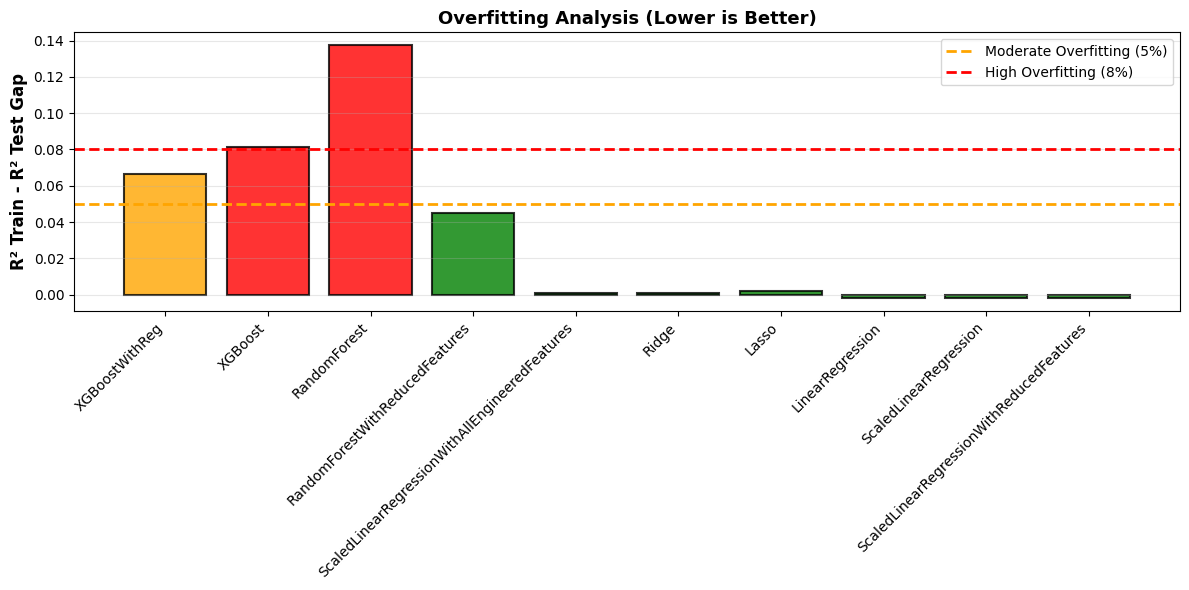

MODEL MONITORING:
XGBoostWithReg                      Gap: 0.0666  Moderate overfitting
XGBoost                             Gap: 0.0811  HIGH overfitting
RandomForest                        Gap: 0.1375  HIGH overfitting
RandomForestWithReducedFeatures     Gap: 0.0448  Good generalization
ScaledLinearRegressionWithAllEngineeredFeatures Gap: 0.0009  Good generalization
Ridge                               Gap: 0.0009  Good generalization
Lasso                               Gap: 0.0019  Good generalization
LinearRegression                    Gap: -0.0019  Good generalization
ScaledLinearRegression              Gap: -0.0019  Good generalization
ScaledLinearRegressionWithReducedFeatures Gap: -0.0015  Good generalization


In [183]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(df))
colors = [
    "red" if gap > 0.08 else "orange" if gap > 0.05 else "green"
    for gap in df["overfit_gap"]
]

ax.bar(x, df["overfit_gap"], color=colors,
       alpha=0.8, edgecolor="black", linewidth=1.5)
ax.axhline(y=0.05, color="orange", linestyle="--", linewidth=2,
           label="Moderate Overfitting (5%)")
ax.axhline(y=0.08, color="red", linestyle="--", linewidth=2,
           label="High Overfitting (8%)")
ax.set_ylabel("R² Train - R² Test Gap", fontsize=12, fontweight="bold")
ax.set_title("Overfitting Analysis (Lower is Better)", fontsize=13, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(df["model_name"], rotation=45, ha="right")
ax.legend()
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("MODEL MONITORING:")
print("=" * 70)
for _, row in df.iterrows():
    gap = row["overfit_gap"]
    if gap > 0.08:
        status = "HIGH overfitting"
    elif gap > 0.05:
        status = "Moderate overfitting"
    else:
        status = "Good generalization"
    print(f"{row['model_name']:35} Gap: {gap:.4f}  {status}")

In [184]:
new_house = pd.DataFrame({
    # Original features
    "bedrooms":       [4],
    "bathrooms":      [2.5],
    "sqft_living":    [2500],
    "sqft_lot":       [10000],
    "floors":         [2],
    "waterfront":     [0],
    "view":           [1],
    "condition":      [3],
    "grade":          [8],
    "sqft_above":     [1800],
    "sqft_basement":  [700],
    "yr_built":       [2000],
    "yr_renovated":   [0],
    "zipcode":        [98001],
    "lat":            [47.52],
    "long":           [-122.31],
    "sqft_living15":  [2400],
    "sqft_lot15":     [9500],
    "year_sold":      [2014],
    "month_sold":     [6],
    "day_of_week":    [3],

    # Engineered features (must match training logic)
    "total_sqft":         [2500 + 700],
    "living_to_lot_ratio":[2500 / 10000],
    "bath_per_bed":       [2.5 / 4],
    "living15_diff":      [2500 - 2400],
    "basement_share":     [700 / (2500 + 700)],
    "has_basement":       [1],
    "lot_per_living":     [10000 / 2500],
    "house_age":          [2014 - 2000],
    "since_renovation":   [2014 - 2000],  # never renovated
    "was_renovated":      [0],            # 0 = never renovated
})



In [185]:
import json

with open("artifacts/registry.json", "r") as f:
    registry = json.load(f)

best_run = max(
    registry,
    key=lambda x: x["metrics"]["test_r2"]  # or -test_rmse
)

best_run["model_config"]["model_name"], best_run["run_id"]


('XGBoostWithReg', '31240d5a-08d9-4979-92a9-3d1e05e59e14')

In [186]:
import joblib

model_path = best_run["artifact_path"]
model = joblib.load(model_path)


In [187]:
new_house = new_house[features_full]

predicted_price = model.predict(new_house)[0]

print("=" * 70)
print("PREDICTION FOR NEW HOUSE")
print("=" * 70)
print("House Features:")
print(f"  Bedrooms:    {new_house['bedrooms'].iloc[0]}")
print(f"  Bathrooms:   {new_house['bathrooms'].iloc[0]}")
print(f"  Living Area: {new_house['sqft_living'].iloc[0]:,} sqft")
print(f"  Built:       {new_house['yr_built'].iloc[0]}")
print(f"\nPREDICTED PRICE: ${predicted_price:,.2f}")
print("=" * 70)

PREDICTION FOR NEW HOUSE
House Features:
  Bedrooms:    4
  Bathrooms:   2.5
  Living Area: 2,500 sqft
  Built:       2000

PREDICTED PRICE: $620,895.19


In [ ]:
! streamlit run app.py